In [1]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer, ClassicalRegister, execute, QuantumCircuit, QuantumRegister
%matplotlib inline

# Algorithm

The class below encapsulates the $\alpha$-Quantum Phase Estimation algorithms for algorithms of the form:
$$\mathcal{A}|0\rangle^{\otimes n} = |\psi_0\rangle|0\rangle + |\psi_1\rangle|1\rangle$$
(hence the "binary" qualifier in the name of the class). The last qubit above in referred to as the "coin quantum register" in the code.

In [2]:
class QuantumBinaryBPE:
    def __init__(self, algo_qc, algo_qrs, coin_qr, ancilla_qr=None):
        """ Create a Quantum Bayesian Phase Estimation instance.
        
        Parameters
        ----------
        algo_qc: QuantumCircuit
            The qiskit circuit implementing the algorithm.
        algo_qrs: list(QuantumRegister)
            A list containing the quantum registers on which the algorithm operates.
        ancilla_qr: QuantumRegister
            An optional quantum register of ancillary qubits to perform the |0>^{\otimes n} flip.
        
        Returns
        -------
        """
        self.algo_qc = algo_qc
        self.algo_qrs = algo_qrs
        self.coin_qr = coin_qr
        self.algo_qubits = reduce(lambda x, y: x + y, [ list(algo_qr) for algo_qr in algo_qrs ], [])
        self.ancilla_qr = ancilla_qr
    
    def flip_0_circuit(self, control_qubit):
        """ Create a controlled quantum circuit that flips the |0>^{\otimes n} computational
        basis vector and leaves the other computational basis vectors unchanged.
        
        Parameters
        ----------
        control_qubit: Qubit
            The qubit controlling the circuit.
        
        Returns
        -------
        QuantumCircuit
            The controlled quantum circuit performing the operation described above.
        """
        qc = QuantumCircuit(*self.algo_qrs, control_qubit.register)
        for algo_qubit in self.algo_qubits:
            qc.x(algo_qubit)
        qc.h(self.algo_qubits[-1])
        if self.ancilla_qr:
            qc.mct([ control_qubit ] + self.algo_qubits[:-1], self.algo_qubits[-1], self.ancilla_qr, mode="basic")
        else:
            qc.mct([ control_qubit ] + self.algo_qubits[:-1], self.algo_qubits[-1], None, mode="noancilla")
        qc.h(self.algo_qubits[-1])
        for algo_qubit in self.algo_qubits:
            qc.x(algo_qubit)
        return qc
    
    def controlled_amplitude_estimation_unitary_circuit(self, control_qubit):
        """ Create a controlled quantum circuit implementing the "amplitude estimation unitary"
        
        Parameters
        ----------
        control_qubit: Qubit
            The qubit controlling the circuit.
            
        Returns
        -------
        QuantumCircuit
            A quantum circuit implementing the controlled amplitude estimation unitary. This unitary
            acts on a 2-dimensional Hilbert space with eigenvalues +/-theta, and the amplitude squared
            a to estimate satisfies a = sin(theta / 2)^2 with our conventions.
        """
        qc = QuantumCircuit(*self.algo_qrs, control_qubit.register)
        qc.x(coin_qr[0])
        qc.cz(control_qubit, coin_qr[0])
        qc.x(coin_qr[0])
        qc += self.algo_qc.inverse()
        qc += self.flip_0_circuit(control_qubit)
        qc += self.algo_qc
        return qc
    
    def elementary_phase_estimation(self, M, theta):
        """ Run a single RFPE circuit instance.
        
        Parameters
        ----------
        M: int
            The power the unitary is raised to in the RFPE circuit.
        theta: float
            The theta (reference phase) parameter of the RFPE circuit.
        
        Returns
        -------
        int
            The classical bit measurement (0/1) returned by one run of the circuit.
        """
        control_qr = QuantumRegister(1)
        control_cr = ClassicalRegister(1)
        algo_circuit = self.controlled_amplitude_estimation_unitary_circuit(control_qr[0])
        qc = QuantumCircuit(*self.algo_qrs, control_qr, control_cr)
        qc += self.algo_qc
        qc.h(control_qr[0])
        qc.rz(-M * theta, control_qr[0])
        for i in range(M):
            qc += algo_circuit
        qc.h(control_qr[0])
        qc.measure(control_qr, control_cr)
        counts = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=1).result().get_counts(qc)
        return 1 if "1" in counts else 0
    
    def estimation_step(self, M, mu, sigma, n_samples):
        """ Perform a single Bayesian update step.
        
        Parameters
        ----------
        M: int
            The power the unitary is raised to in the RFPE circuit.
        mu: float
            The mean of the prior phase distribution.
        sigma: float
            The standard deviation of the prior phase distribution.
        n_samples: int
            The number of phase samples to draw from the prior phase distribution in the Bayesian
            update step.
        
        Returns
        -------
        tuple
            A pair whose first element is the mean, second element the standard deviation of the
            posterior phase distribution.
        """
        # Set theta parameter
        theta = mu + sigma * np.random.randn()
        # Observe outcome from circuit
        outcome = self.elementary_phase_estimation(M, theta)
        # Sample phases from prior distribution and estimate the posterior one
        # by rejection sampling
        phis = mu + sigma * np.random.randn(n_samples)
        accepted_phis = []
        for phi in phis:
            if np.random.uniform() < (1 + (-1) ** outcome * np.cos(M * (phi + theta))) / 2:
                accepted_phis.append(phi)
        return np.mean(accepted_phis), np.std(accepted_phis)
    
    def alpha_qpe(self, alpha, precision, n_initial_samples, n_samples_per_iteration, max_iterations):
        """ Run the alpha-QPE algorithm and output estimated phase with uncertainty.
        
        Parameters
        ----------
        alpha: float
            The alpha parameter of the alpha-QPE algorithm.
        precision: float
            The target maximum value for the phase uncertainty. The algorithm stops once this level
            has been reached.
        n_initial_samples: int
            Number of samples to draw to obtain an estimate of the phase from classical Monte Carlo.
        n_samples_per_iteration: int
            The number of phase samples to draw at each Bayesian update step.
        max_iterations: int
            The maximum number of Bayesian update steps. The algorithm stops once this has been reached
            (even if the target precision has not).
        
        
        Returns
        -------
        tuple
            A pair whose first element is the estimated phase and second element the uncertainty
            on it.
        """
        # Statistically sample the state to get an estimate of the phase.
        coin_cr = ClassicalRegister(1)
        qc = QuantumCircuit(coin_qr, coin_cr)
        qc += self.algo_qc
        qc.measure(coin_qr, coin_cr)
        counts = execute(qc, BasicAer.get_backend("qasm_simulator"), shots=n_initial_samples).result().get_counts()
        estimated_probability = counts.get("1", 0) / (counts.get("0", 0) + counts.get("1", 0))
        print ("estimated probability (statistical sampling): {}".format(estimated_probability))
        estimated_phase = 2 * np.arcsin(np.sqrt(estimated_probability))
        print ("estimated phase (statistical sampling): {}".format(estimated_phase))
        estimated_phase_lbound = max(-2 * np.pi, 2 * np.arcsin(np.sqrt(estimated_probability * (1 - 3 * (1 - estimated_probability) / np.sqrt(n_initial_samples)))))
        estimated_phase_ubound = min(2 * np.pi, 2 * np.arcsin(np.sqrt(estimated_probability * (1 + 3 * (1 - estimated_probability) / np.sqrt(n_initial_samples)))))
        initial_sigma = 2 * max(estimated_phase_ubound - estimated_phase, estimated_phase - estimated_phase_lbound)
        if initial_sigma == 0:
            initial_sigma = np.pi
        # Iterate the RFPE algorithm. For each iteration, try to increase the component of one of the two
        # eigenvectors of the amplitude estimation unitary. If this succeeds, perform RFPE on the resulting
        # state (using either the amplitude estimation unitary or its dagger depending on which eigenvector
        # had their component increased).
        mu, sigma = estimated_phase, initial_sigma
        for iteration in range(max_iterations):
            print ("iteration {}".format(iteration))
            first_measurement = self.elementary_phase_estimation(2, 0)
            if first_measurement == 0:
                print ("eigenstate amplification failed, skipping RFPE")
                continue
            second_measurement = self.elementary_phase_estimation(1, first_measurement * np.pi / 2)
            M = int(1.154 / sigma) if alpha == 1 else int(1.0 / sigma ** alpha)
            mu, sigma = self.estimation_step(M, mu, sigma, n_samples_per_iteration)
            print ("posterior estimate: ({}, {})".format(mu, sigma))
            if sigma < precision:
                break
        return mu, sigma

# Test

In this test, the state prepared by the algorithm is simply $\cos\frac{\theta}{2}|0\rangle + \sin\frac{\theta}{2}|1\rangle$ and the phase to be estimated is then $\theta$.

In [3]:
theta = np.pi / 5

In [4]:
precision = 1e-2
max_iterations = 10000
n_samples_per_iteration = 1000

In [5]:
coin_qr = QuantumRegister(1)
qc = QuantumCircuit(coin_qr)
qc.ry(theta, coin_qr[0])

In [6]:
bpe = QuantumBinaryBPE(algo_qc=qc, algo_qrs=[coin_qr], coin_qr=coin_qr)

## $\alpha = 1$

In [7]:
n_experiments = 50
estimates = []
for experiment in range(n_experiments):
    print ("experiment {}".format(experiment))
    result = bpe.alpha_qpe(
        alpha=1,
        precision=precision,
        n_initial_samples=min(65536, int(1 / precision)),
        n_samples_per_iteration=n_samples_per_iteration,
        max_iterations=max_iterations
    )
    estimates.append(result[0])

experiment 0
estimated probability (statistical sampling): 0.1
estimated phase (statistical sampling): 0.6435011087932844
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
eigenstate amplification failed, skipping RFPE
iteration 7
eigenstate amplification failed, skipping RFPE
iteration 8
eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigenstate amplification failed, sk

eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
eigenstate amplification failed, skipping RFPE
iteration 49
eigenstate amplification failed, skipping RFPE
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skipping RFPE
iteration 53
eigenstate amplification failed, skipping RFPE
iteration 54
eigenstate amplification failed, skipping RFPE
iteration 55
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
posterior estimate: (0.6415435290652733, 0.01996048515272504)
iteration 190
posterior estimate: (0.6320780884220335, 0.014882895700879783)
iteration 191
posterior estimate: (0.6416510641186524, 0.013914499736515713)
iteration 192
posterior estimate: (0.633039581836514, 0.011580363341263123)
iteration 193
posterior estimate: (0.6339483719384852, 0.008587379904652833)
experiment 2
estimated probability (statistical sampling): 0.14
estimated phase (statistical sampling): 0.7669940078618667
iteration 0
eigensta

eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification failed, skipping RFPE
iteration 135
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 250
eigenstate amplification failed, skipping RFPE
iteration 251
eigenstate amplification failed, skipping RFPE
iteration 252
eigenstate amplification failed, skipping RFPE
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skipping RFPE
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
eigenstate amplification failed, skipping RFPE
iteration 257
eigenstate amplification failed, skipping RFPE
iteration 258
eigenstate amplification failed, skipping RFPE
iteration 259
eigenstate amplification failed, skipping RFPE
iteration 260
eigenstate amplification failed, skipping RFPE
iteration 261
eigenstate amplification failed, skipping RFPE
iteration 262
eigenstate amplification failed, skipping RFPE
iteration 263
eigenstate amplification failed, skipping RFPE
iteration 264
eigenstate amplification failed, skipping RFPE
iteration 265
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping

posterior estimate: (0.5534186046659498, 0.10312555933173508)
iteration 146
posterior estimate: (0.5729118858657583, 0.07583736138172695)
iteration 147
posterior estimate: (0.6242947761592182, 0.07580148432349455)
iteration 148
eigenstate amplification failed, skipping RFPE
iteration 149
eigenstate amplification failed, skipping RFPE
iteration 150
eigenstate amplification failed, skipping RFPE
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
posterior estimate: (0.6069751331440629, 0.05678138357068331)
iteration 156
posterior estimate: (0.6338656127326074, 0.04457386330852634)
iteration 157
posterior estimate: (0.6560683644967058, 0.03541921958037978)
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration

eigenstate amplification failed, skipping RFPE
iteration 276
eigenstate amplification failed, skipping RFPE
iteration 277
posterior estimate: (0.6118265173002276, 0.008604886412389027)
experiment 5
estimated probability (statistical sampling): 0.08
estimated phase (statistical sampling): 0.5735131044230968
iteration 0
posterior estimate: (0.5763189125874234, 0.13245845747855436)
iteration 1
posterior estimate: (0.5960385845962822, 0.1003837315783276)
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
eigenstate amplification failed, skipping RFPE
iteration 7
eigenstate amplification failed, skipping RFPE
iteration 8
eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 11


eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
posterior estimate: (0.6922140336780114, 0.06888010795464831)
iteration 73
posterior estimate: (0.6615864814694558, 0.05388007664437709)
iteration 74
posterior estimate: (0.6225358395643534, 0.06477732637337599)
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 89
eigenstate amplification failed, skipping RFPE
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenstate amplification failed, skipping RFPE
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, sk

posterior estimate: (0.6414168078178, 0.022971462355286375)
iteration 97
posterior estimate: (0.6520486519536612, 0.017405372245508755)
iteration 98
posterior estimate: (0.6495367629914521, 0.01336426760571617)
iteration 99
posterior estimate: (0.6403452629749089, 0.014361767728828542)
iteration 100
posterior estimate: (0.6453163705362375, 0.010556316451409564)
iteration 101
posterior estimate: (0.6484705006368021, 0.0077862233796180125)
experiment 9
estimated probability (statistical sampling): 0.1
estimated phase (statistical sampling): 0.6435011087932844
iteration 0
posterior estimate: (0.7801512377359067, 0.25402134811126026)
iteration 1
posterior estimate: (0.8288060584059653, 0.19017966684103207)
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplification failed, skipping RFPE
iteration 294
eigenstate amplification failed, skipping RFPE
iteration 295
eigenstate amplification failed, skipping RFPE
iteration 296
eigenstate amplification failed, skipping RFPE
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
eigenstate amplification

posterior estimate: (0.6357884344071747, 0.016895463411359963)
iteration 87
posterior estimate: (0.6256526195050613, 0.02181820970569029)
iteration 88
posterior estimate: (0.6232850113671434, 0.016910306816761315)
iteration 89
posterior estimate: (0.6356648761381635, 0.01635424448745132)
iteration 90
posterior estimate: (0.6403204673595908, 0.012099922389534638)
iteration 91
posterior estimate: (0.6316342386746507, 0.010416680707756292)
iteration 92
posterior estimate: (0.634932583308629, 0.0078387881092851)
experiment 12
estimated probability (statistical sampling): 0.08
estimated phase (statistical sampling): 0.5735131044230968
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
posterior estimate: (0.4683989043808836, 0.11507170117038366)
iteration 83
posterior estimate: (0.5101033394044534, 0.08509484299985978)
iteration 84
posterior estimate: (0.5137716591512643, 0.13119557521054656)
iteration 85
posterior estimate: (0.43247135500699807, 0.17755603553331556)
iteration 86
posterior estimate: (0.5357508275833809

posterior estimate: (0.6205030805179358, 0.008548896041404935)
experiment 14
estimated probability (statistical sampling): 0.11
estimated phase (statistical sampling): 0.6761305095606613
iteration 0
posterior estimate: (0.6310917225436972, 0.1586526797656263)
iteration 1
posterior estimate: (0.5242475656155563, 0.14055348579565136)
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
eigenstate amplification failed, skipping RFPE
iteration 7
eigenstate amplification failed, skipping RFPE
iteration 8
eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
e

eigenstate amplification failed, skipping RFPE
iteration 135
eigenstate amplification failed, skipping RFPE
iteration 136
eigenstate amplification failed, skipping RFPE
iteration 137
eigenstate amplification failed, skipping RFPE
iteration 138
eigenstate amplification failed, skipping RFPE
iteration 139
eigenstate amplification failed, skipping RFPE
iteration 140
eigenstate amplification failed, skipping RFPE
iteration 141
eigenstate amplification failed, skipping RFPE
iteration 142
eigenstate amplification failed, skipping RFPE
iteration 143
eigenstate amplification failed, skipping RFPE
iteration 144
eigenstate amplification failed, skipping RFPE
iteration 145
eigenstate amplification failed, skipping RFPE
iteration 146
posterior estimate: (0.6155080470902098, 0.010303309129117364)
iteration 147
posterior estimate: (0.6172331461394064, 0.01601815244942086)
iteration 148
posterior estimate: (0.6068959260425173, 0.013353391759428066)
iteration 149
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
posterior estimate: (0.6078773363906587, 0.009091483762365033)
experiment 16
estimated probability (statistical sampling): 0.08
estimated phase (statistical sampling): 0.5735131044230968
iteration 0
posterior estimate: (0.5446548158040744, 0.12739225924037378)
iteration 1
posterior estimate: (0.48166306365767414, 0.10358069433413168)
iteration 2
posterior estimate: (0.4008949458802663, 0.10839145208675245)
iteration 3
posterior estimate: (0.470264

posterior estimate: (0.6098703587551092, 0.026273694490972384)
iteration 123
posterior estimate: (0.6140589236973811, 0.020437841486958753)
iteration 124
posterior estimate: (0.6010301031963736, 0.01943395450845613)
iteration 125
posterior estimate: (0.6156734787704856, 0.01580545238664984)
iteration 126
posterior estimate: (0.6055396603248833, 0.016600601601974685)
iteration 127
posterior estimate: (0.61482237272221, 0.021558603997684465)
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification failed, skipping RFPE
iteration 135
eigenstate amplification failed, skipping RFPE
iteration 136
eigenstate amplification failed, skipping RFPE
iterati

eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
eigenstate amplification failed, skipping RFPE
iteration 69
eigenstate amplification failed, skipping RFPE
iteration 70
eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification

posterior estimate: (0.6827699396654483, 0.022640230636751274)
iteration 90
posterior estimate: (0.6765161980885956, 0.03605259338664741)
iteration 91
posterior estimate: (0.6535954416010208, 0.0316269248298887)
iteration 92
posterior estimate: (0.638549264326121, 0.04368015379537369)
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
posterior estimate: (0.6551504363780184, 0.03200317767709672)
iteration 100
posterior estimate: (0.6473732842292287, 0.02340333288422106)
iteration 101
posterior estimate: (0.6523049767448014, 0.017462723312129124)
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iter

posterior estimate: (0.30335080468305353, 0.17467259323103865)
iteration 10
posterior estimate: (0.4358222551835251, 0.16307576917613845)
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
posterior estimate: (0.541134507944716, 0.19872370890636284)
iteration 19
posterior estimate: (0.5316588000240107, 0.1550670786394106)
iteration 20
posterior estimate: (0.5750734547544896, 0.11391033504160829)
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification f

posterior estimate: (0.5731774997752306, 0.05690126119056215)
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification 

eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
posterior estimate: (0.5161585482271798, 0.09294875724064107)
iteration 48
posterior estimate: (0.5740526719145553, 0.08782044271866103)
iteration 49
posterior estimate: (0.505759002161166, 0.07696697208027484)
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skipping RFPE
iteration 53
eigenstate amplification failed, skipping RFPE
iteration

posterior estimate: (0.6451254781033694, 0.03359147511710965)
iteration 170
posterior estimate: (0.6583185422296068, 0.024964972035845277)
iteration 171
posterior estimate: (0.644889147933962, 0.01947854052687816)
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
posterior estimate: (0.6591719102445343, 0.018284906192590586)
iteration 180
posterior estimate: (0.6698683184825742, 0.024287639532438447)
iteration 181
posterior estimate: (0.6834044865374604, 0.03176516444418835)
iteration 182
posterior estimate: (0.6646234030377577, 0.03755496515005078)
iteration 183
posterior estimate: (0.6675028149639537

posterior estimate: (0.9521147094769404, 0.0348229635661998)
iteration 71
posterior estimate: (0.925663332524836, 0.03675392668246064)
iteration 72
posterior estimate: (0.9315409462008909, 0.057779106549638456)
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration

posterior estimate: (0.6335992555756268, 0.10273696371892037)
iteration 24
posterior estimate: (0.5649461265438843, 0.10440902622192914)
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
posterior estimate: (0.5813771310102167, 0.07748241116985541)
iteration 32
posterior estimate: (0.5615306261109478, 0.058266993985612574)
iteration 33
posterior estimate: (0.5831771657401423, 0.08617615458775431)
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification

posterior estimate: (0.4491845661508393, 0.11309772365171188)
iteration 153
posterior estimate: (0.5107321742589952, 0.086075205505234)
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 

eigenstate amplification failed, skipping RFPE
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
eigenstate amplification failed, skipping RFPE
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplification failed, skipping RFPE
iteration 294
eigenstate amplification failed, skipping RFPE
iteration 295
eigenstate amplification failed, skipping RFPE
iteration 296
eigenstate amplification failed, skipping RFPE
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
posterior estimate: (0.6499850753662674, 0.03535874420332024)
iteration 82
posterior estimate: (0.6342995999630073, 0.025984773297581684)
iteration 83
posterior estimate: (0.6139886777641167, 0.024930717056089974)
iteration 84
posterior estimate: (0.5988921313076185, 0.019944310807642637)
iteration 85
posterior estimate: (0.586126056711773, 0.016039798662679076)
iteration 86
posterior estimate: (0.5748960617250344, 0.01749464295955695)
iteration 87
eigenstate amplification failed, skipping RFPE
iteration 88
eigenstate amplification failed, skipping RFPE
iteration 89
eigenstate amplification failed, skipping RFPE
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenst

eigenstate amplification failed, skipping RFPE
iteration 209
eigenstate amplification failed, skipping RFPE
iteration 210
eigenstate amplification failed, skipping RFPE
iteration 211
eigenstate amplification failed, skipping RFPE
iteration 212
eigenstate amplification failed, skipping RFPE
iteration 213
eigenstate amplification failed, skipping RFPE
iteration 214
eigenstate amplification failed, skipping RFPE
iteration 215
eigenstate amplification failed, skipping RFPE
iteration 216
eigenstate amplification failed, skipping RFPE
iteration 217
eigenstate amplification failed, skipping RFPE
iteration 218
eigenstate amplification failed, skipping RFPE
iteration 219
eigenstate amplification failed, skipping RFPE
iteration 220
eigenstate amplification failed, skipping RFPE
iteration 221
eigenstate amplification failed, skipping RFPE
iteration 222
eigenstate amplification failed, skipping RFPE
iteration 223
eigenstate amplification failed, skipping RFPE
iteration 224
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
posterior estimate: (0.5872195401968043, 0.04101755556905345)
iteration 116
posterior estimate: (0.6135132160159179, 0.028796744060600787)
iteration 117
posterior estimate: (0.623267719632876, 0.021526206974034488)
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification

posterior estimate: (0.6832393783316141, 0.07498693390758569)
iteration 87
posterior estimate: (0.6473494065973862, 0.057483439445475924)
iteration 88
posterior estimate: (0.6439844257791271, 0.04349531275502517)
iteration 89
eigenstate amplification failed, skipping RFPE
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenstate amplification failed, skipping RFPE
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
itera

eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
posterior estimate: (0.6148075002308104, 0.008798474974370028)
experiment 33
estimated probability (statistical sampling): 0.1
estimated phase (statistical sampling): 0.6435011087932844
iteration 0
posterior estimate: (0

posterior estimate: (0.5596888617741673, 0.14362085951824924)
iteration 16
posterior estimate: (0.6666165393907235, 0.10247822358914166)
iteration 17
posterior estimate: (0.6010018444760661, 0.11201015486140932)
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
posterior estimate: (0.5812001958900102, 0.08310779815945696)
iteration 26
posterior estimate: (0.6092293123526388, 0.06085123353610183)
iteration 27
posterior estimate: (0.5623315119289153, 0.05759423804234377)
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate

posterior estimate: (0.6059438433061501, 0.025777423927988437)
iteration 95
posterior estimate: (0.6064568174683912, 0.019372721388239332)
iteration 96
posterior estimate: (0.6172216064036472, 0.013824776810122378)
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
posterior estimate: (0.6214352201984497, 0.010273507493331094)
iteration 105
posterior estimate: (0.6212146912766636, 0.007790580053363452)
experiment 36
estimated probability (statistical sampling): 0.09
estimated phase (statistical sampling): 0.609385308030795
iteration 0
posterior estimate: (0.6761510770822928, 0.14038853963844686)
iteration 

eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 148
eigenstate amplification failed, skipping RFPE
iteration 149
eigenstate amplification failed, skipping RFPE
iteration 150
eigenstate amplification failed, skipping RFPE
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration 86
eigenstate amplification failed, skipping RFPE
iteration 87
posterior estimate: (1.1573320499716793, 0.0178180257537388)
iteration 88
posterior estimate: (1.157962637194531, 0.01353212999490526)
iteration 89
posterior estimate: (1.1552075468808913, 0.010527407318352102)
iteration

eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
posterior estimate: (0.6654200841639597, 0.05382584517016061)
iteration 102
posterior estimate: (0.6637441939282224, 0.03937962441679129)
iteration 103
posterior estimate: (0.6712629968652515, 0.029949904078191508)
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
posterior estimate: (0.6927740112933577, 0

posterior estimate: (0.8121960799490057, 0.12310924104889544)
iteration 10
posterior estimate: (0.7565499739126971, 0.09481065708838113)
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate

posterior estimate: (0.7524448908682785, 0.02073355032407617)
iteration 145
posterior estimate: (0.7466285857293808, 0.01530892915944648)
iteration 146
posterior estimate: (0.7351758597460767, 0.015056363649333377)
iteration 147
eigenstate amplification failed, skipping RFPE
iteration 148
eigenstate amplification failed, skipping RFPE
iteration 149
eigenstate amplification failed, skipping RFPE
iteration 150
eigenstate amplification failed, skipping RFPE
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
posterior estimate: (0.7344271651099914, 0.022660228728527153)
iteration 155
posterior estimate: (0.746250780665249, 0.0285130871150667)
iteration 156
posterior estimate: (0.7646939237436887, 0.024539852517622397)
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration 86
eigenstate amplification failed, skipping RFPE
iteration 87
eigenstate amplification failed, skipping RFPE
iteration 88
posterior estimate: (0.5939983553859032, 0.02080153576254477)
iteration 89
posterior estimate: (0.6052460064934814, 0.01621257214894422)
iteration 90
posterior estimate: (0.6020126152903995, 0.023254445710620974)
iteration 91
posterior estimate: (0.6128987900922326, 0.017734380299004864)
iteration 92
posterior estimate: (0.6246810896092615, 0.014721653006323783)
iteration 93
posterior estimate: (0.6242413262497891, 0.02355877463159287)
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenst

posterior estimate: (0.7726879933897663, 0.03585752720737938)
iteration 48
posterior estimate: (0.7722840731825661, 0.05565213595198255)
iteration 49
posterior estimate: (0.7358636705517266, 0.0645411266567685)
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skipping RFPE
iteration 53
eigenstate amplification failed, skipping RFPE
iteration 54
eigenstate amplification failed, skipping RFPE
iteration 55
eigenstate amplification failed, skipping RFPE
iteration 56
eigenstate amplification failed, skipping RFPE
iteration 57
eigenstate amplification failed, skipping RFPE
iteration 58
eigenstate amplification failed, skipping RFPE
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration

posterior estimate: (0.6423269756967683, 0.02198511014802558)
iteration 178
posterior estimate: (0.6264259321560227, 0.02182113184431154)
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 319
eigenstate amplification failed, skipping RFPE
iteration 320
eigenstate amplification failed, skipping RFPE
iteration 321
eigenstate amplification failed, skipping RFPE
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
eigenstate amplification failed, skipping RFPE
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
posterior estimate: (0.5975842387594302, 0.04109361502318502)
iteration 334
posterior

eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
posterior estimate: (0.5606272407238455, 0.019551561871691884)
iteration 120
posterior estimate: (0.5511474635500611, 0.015422903966277856)
iteration 121
posterior estimate: (0.5522136198586138, 0.011242514165623576)
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skip

eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
posterior estimate: (0.6488386732149544, 0.008543895199767082)
experiment 48
estimated probability (statistical sampling): 0.05
estimated phase (statistical sampling): 0.4510268117962624
iteration 0
posterior estimate: (0.42898223743897795, 0.21827628026512189)
iteration 1
posterior estimate: (0.5261264074709725, 0.168596552364

eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification failed, skipping RFPE
iteration 135
eigenstate amplification failed, skipping RFPE
iteration 136
eigenstate amplification failed, skipping RFPE
iteration 137
eigenstate amplification failed, skipping RFPE
iteration 138
eigenstate amplification failed, skipping RFPE
iteration 139
eigenstate amplification failed, skipping RFPE
iteration 140
eigenstate amplification failed, skipping RFPE
iteration 141
eigenstate amplification

posterior estimate: (0.30242662230538636, 0.015986052196175472)
iteration 261
posterior estimate: (0.31139483430243486, 0.020557905732733653)
iteration 262
posterior estimate: (0.30054732204755913, 0.014690094993200073)
iteration 263
eigenstate amplification failed, skipping RFPE
iteration 264
eigenstate amplification failed, skipping RFPE
iteration 265
eigenstate amplification failed, skipping RFPE
iteration 266
eigenstate amplification failed, skipping RFPE
iteration 267
eigenstate amplification failed, skipping RFPE
iteration 268
eigenstate amplification failed, skipping RFPE
iteration 269
eigenstate amplification failed, skipping RFPE
iteration 270
eigenstate amplification failed, skipping RFPE
iteration 271
eigenstate amplification failed, skipping RFPE
iteration 272
eigenstate amplification failed, skipping RFPE
iteration 273
eigenstate amplification failed, skipping RFPE
iteration 274
eigenstate amplification failed, skipping RFPE
iteration 275
eigenstate amplification failed, s

eigenstate amplification failed, skipping RFPE
iteration 101
posterior estimate: (0.6407218516302207, 0.008312206710922239)


majoritary bin: 0.6117740288180626 - 0.622199620984171


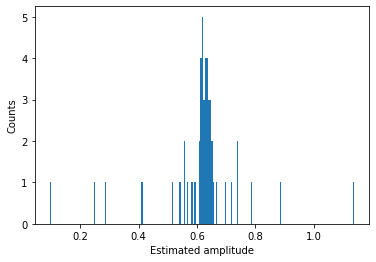

In [8]:
hist = plt.hist(estimates, bins=200)
plt.xlabel("Estimated amplitude")
plt.ylabel("Counts")
print("majoritary bin: {} - {}".format(hist[1][np.argmax(hist[0]) - 1], hist[1][np.argmax(hist[0]) + 1]))

In [9]:
hist

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 4., 5., 3.,
        4., 4., 3., 3., 2., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.09570722, 0.10092001, 0.10613281, 0.1113456 , 0.1165584 ,
        0.1217712 , 0.12698399, 0.

## $\alpha = 0.6$

In [10]:
n_experiments = 50
estimates = []
for experiment in range(n_experiments):
    print ("experiment {}".format(experiment))
    result = bpe.alpha_qpe(
        alpha=0.6,
        precision=precision,
        n_initial_samples=min(65536, int(1 / precision)),
        n_samples_per_iteration=n_samples_per_iteration,
        max_iterations=max_iterations
    )
    estimates.append(result[0])

experiment 0
estimated probability (statistical sampling): 0.12
estimated phase (statistical sampling): 0.7074832117793429
iteration 0
posterior estimate: (0.7269498339679326, 0.19486511350565439)
iteration 1
posterior estimate: (0.587535069214293, 0.3199359901791414)
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
eigenstate amplification failed, skipping RFPE
iteration 7
eigenstate amplification failed, skipping RFPE
iteration 8
eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 11
eigenstate amplification failed, skipping RFPE
iteration 12
eigenstate amplification failed, skipping RFPE
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigens

eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
posterior estimate: (0.5330466313319108, 0.17198909625639958)
iteration 135
posterior estimate: (0.5567556441635059, 0.16225635917461534)
iteration 136
posterior estimate: (0.4553779081922201, 0.14429076830811297)
iteration 137
eigenstate amplification failed, skipping RFPE
iteration 138
eigenstate amplification failed, skipping RFPE
iteration 139
eigenstate amplification failed, skipping RFPE
iteration 140
eigenstate amplification failed, skipping RFPE
iteration 141
eigenstate amplification failed, skipping RFPE
iteration 142
eigenstate amplification failed, skipping RFPE
iteration 143
eigenstate amplification failed, skipping RFPE
iteration 144
eigenstate amplification failed, skipping RFPE
iteration 145
eigenstate amplification failed, skippin

posterior estimate: (0.5656930216865925, 0.06470848346129651)
iteration 262
posterior estimate: (0.5699435448292552, 0.060430831207975814)
iteration 263
posterior estimate: (0.5755492080967073, 0.0598575931677008)
iteration 264
posterior estimate: (0.5819909162744658, 0.05679244646016524)
iteration 265
posterior estimate: (0.5838208978878634, 0.05728729519410656)
iteration 266
posterior estimate: (0.5881138890630713, 0.05696132831416849)
iteration 267
posterior estimate: (0.5885635940072708, 0.056364366941178294)
iteration 268
eigenstate amplification failed, skipping RFPE
iteration 269
eigenstate amplification failed, skipping RFPE
iteration 270
eigenstate amplification failed, skipping RFPE
iteration 271
eigenstate amplification failed, skipping RFPE
iteration 272
eigenstate amplification failed, skipping RFPE
iteration 273
eigenstate amplification failed, skipping RFPE
iteration 274
eigenstate amplification failed, skipping RFPE
iteration 275
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 392
eigenstate amplification failed, skipping RFPE
iteration 393
eigenstate amplification failed, skipping RFPE
iteration 394
eigenstate amplification failed, skipping RFPE
iteration 395
eigenstate amplification failed, skipping RFPE
iteration 396
eigenstate amplification failed, skipping RFPE
iteration 397
eigenstate amplification failed, skipping RFPE
iteration 398
eigenstate amplification failed, skipping RFPE
iteration 399
eigenstate amplification failed, skipping RFPE
iteration 400
eigenstate amplification failed, skipping RFPE
iteration 401
eigenstate amplification failed, skipping RFPE
iteration 402
eigenstate amplification failed, skipping RFPE
iteration 403
eigenstate amplification failed, skipping RFPE
iteration 404
eigenstate amplification failed, skipping RFPE
iteration 405
eigenstate amplification failed, skipping RFPE
iteration 406
eigenstate amplification failed, skipping RFPE
iteration 407
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 530
eigenstate amplification failed, skipping RFPE
iteration 531
eigenstate amplification failed, skipping RFPE
iteration 532
eigenstate amplification failed, skipping RFPE
iteration 533
eigenstate amplification failed, skipping RFPE
iteration 534
eigenstate amplification failed, skipping RFPE
iteration 535
eigenstate amplification failed, skipping RFPE
iteration 536
eigenstate amplification failed, skipping RFPE
iteration 537
eigenstate amplification failed, skipping RFPE
iteration 538
posterior estimate: (0.616009152526417, 0.0333687934027256)
iteration 539
posterior estimate: (0.6196490161760474, 0.032145936468354175)
iteration 540
posterior estimate: (0.6017898636723862, 0.02920876628992598)
iteration 541
eigenstate amplification failed, skipping RFPE
iteration 542
eigenstate amplification failed, skipping RFPE
iteration 543
eigenstate amplification failed, skipping RFPE
iteration 544
eigenstate amplification failed, skipping

eigenstate amplification failed, skipping RFPE
iteration 663
eigenstate amplification failed, skipping RFPE
iteration 664
eigenstate amplification failed, skipping RFPE
iteration 665
eigenstate amplification failed, skipping RFPE
iteration 666
posterior estimate: (0.6118899867677816, 0.02027977729565257)
iteration 667
posterior estimate: (0.6118347202865208, 0.01975571424338753)
iteration 668
posterior estimate: (0.611929921173228, 0.019937935018046325)
iteration 669
eigenstate amplification failed, skipping RFPE
iteration 670
eigenstate amplification failed, skipping RFPE
iteration 671
eigenstate amplification failed, skipping RFPE
iteration 672
eigenstate amplification failed, skipping RFPE
iteration 673
eigenstate amplification failed, skipping RFPE
iteration 674
eigenstate amplification failed, skipping RFPE
iteration 675
eigenstate amplification failed, skipping RFPE
iteration 676
eigenstate amplification failed, skipping RFPE
iteration 677
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 799
eigenstate amplification failed, skipping RFPE
iteration 800
eigenstate amplification failed, skipping RFPE
iteration 801
eigenstate amplification failed, skipping RFPE
iteration 802
eigenstate amplification failed, skipping RFPE
iteration 803
eigenstate amplification failed, skipping RFPE
iteration 804
eigenstate amplification failed, skipping RFPE
iteration 805
eigenstate amplification failed, skipping RFPE
iteration 806
eigenstate amplification failed, skipping RFPE
iteration 807
eigenstate amplification failed, skipping RFPE
iteration 808
eigenstate amplification failed, skipping RFPE
iteration 809
eigenstate amplification failed, skipping RFPE
iteration 810
eigenstate amplification failed, skipping RFPE
iteration 811
eigenstate amplification failed, skipping RFPE
iteration 812
eigenstate amplification failed, skipping RFPE
iteration 813
eigenstate amplification failed, skipping RFPE
iteration 814
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 930
eigenstate amplification failed, skipping RFPE
iteration 931
eigenstate amplification failed, skipping RFPE
iteration 932
eigenstate amplification failed, skipping RFPE
iteration 933
eigenstate amplification failed, skipping RFPE
iteration 934
eigenstate amplification failed, skipping RFPE
iteration 935
eigenstate amplification failed, skipping RFPE
iteration 936
eigenstate amplification failed, skipping RFPE
iteration 937
eigenstate amplification failed, skipping RFPE
iteration 938
eigenstate amplification failed, skipping RFPE
iteration 939
eigenstate amplification failed, skipping RFPE
iteration 940
eigenstate amplification failed, skipping RFPE
iteration 941
eigenstate amplification failed, skipping RFPE
iteration 942
eigenstate amplification failed, skipping RFPE
iteration 943
eigenstate amplification failed, skipping RFPE
iteration 944
posterior estimate: (0.6173464803704442, 0.01707513160623188)
iteration 945
posterior

posterior estimate: (0.6180720473173613, 0.013351664326935726)
iteration 1060
posterior estimate: (0.617727103655737, 0.013031847586835205)
iteration 1061
eigenstate amplification failed, skipping RFPE
iteration 1062
eigenstate amplification failed, skipping RFPE
iteration 1063
eigenstate amplification failed, skipping RFPE
iteration 1064
eigenstate amplification failed, skipping RFPE
iteration 1065
eigenstate amplification failed, skipping RFPE
iteration 1066
eigenstate amplification failed, skipping RFPE
iteration 1067
eigenstate amplification failed, skipping RFPE
iteration 1068
eigenstate amplification failed, skipping RFPE
iteration 1069
eigenstate amplification failed, skipping RFPE
iteration 1070
eigenstate amplification failed, skipping RFPE
iteration 1071
eigenstate amplification failed, skipping RFPE
iteration 1072
eigenstate amplification failed, skipping RFPE
iteration 1073
eigenstate amplification failed, skipping RFPE
iteration 1074
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 1196
eigenstate amplification failed, skipping RFPE
iteration 1197
eigenstate amplification failed, skipping RFPE
iteration 1198
eigenstate amplification failed, skipping RFPE
iteration 1199
eigenstate amplification failed, skipping RFPE
iteration 1200
posterior estimate: (0.6053427929836953, 0.011392122856000782)
iteration 1201
posterior estimate: (0.6033928907034398, 0.010870991192280587)
iteration 1202
posterior estimate: (0.603683581950861, 0.010577667139774455)
iteration 1203
posterior estimate: (0.6004513853054761, 0.010068061639887679)
iteration 1204
posterior estimate: (0.6008297869478929, 0.009681396351318055)
experiment 1
estimated probability (statistical sampling): 0.06
estimated phase (statistical sampling): 0.4949341263408955
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eige

eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 249
eigenstate amplification failed, skipping RFPE
iteration 250
eigenstate amplification failed, skipping RFPE
iteration 251
eigenstate amplification failed, skipping RFPE
iteration 252
eigenstate amplification failed, skipping RFPE
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skipping RFPE
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
posterior estimate: (0.41702783174991526, 0.06928616569899308)
iteration 257
posterior estimate: (0.41577063234324096, 0.06996333103521085)
iteration 258
posterior estimate: (0.4172665439498445, 0.07011532633216559)
iteration 259
posterior estimate: (0.41496209866563044, 0.06952246971391803)
iteration 260
posterior estimate: (0.410509762531235, 0.07043942183272052)
iteration 261
posterior estimate: (0.48253974042325404, 0.07914386455910834)
iteration 262
eigenstate amplification failed, skipping RFPE
iterat

eigenstate amplification failed, skipping RFPE
iteration 376
eigenstate amplification failed, skipping RFPE
iteration 377
eigenstate amplification failed, skipping RFPE
iteration 378
eigenstate amplification failed, skipping RFPE
iteration 379
eigenstate amplification failed, skipping RFPE
iteration 380
eigenstate amplification failed, skipping RFPE
iteration 381
eigenstate amplification failed, skipping RFPE
iteration 382
eigenstate amplification failed, skipping RFPE
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
eigenstate amplification failed, skipping RFPE
iteration 385
eigenstate amplification failed, skipping RFPE
iteration 386
eigenstate amplification failed, skipping RFPE
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
eigenstate amplification failed, skipping RFPE
iteration 391
eigenstate amplification

posterior estimate: (0.5341127794994789, 0.021560514360569823)
iteration 509
posterior estimate: (0.5341028286124286, 0.020455795470230645)
iteration 510
posterior estimate: (0.5370146012808475, 0.02091649693597031)
iteration 511
posterior estimate: (0.5445671816840766, 0.020118888681427895)
iteration 512
eigenstate amplification failed, skipping RFPE
iteration 513
eigenstate amplification failed, skipping RFPE
iteration 514
eigenstate amplification failed, skipping RFPE
iteration 515
eigenstate amplification failed, skipping RFPE
iteration 516
eigenstate amplification failed, skipping RFPE
iteration 517
eigenstate amplification failed, skipping RFPE
iteration 518
eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification failed, skipping RFPE
iteration 520
eigenstate amplification failed, skipping RFPE
iteration 521
eigenstate amplification failed, skipping RFPE
iteration 522
eigenstate amplification failed, skipping RFPE
iteration 523
eigenstate amplificati

eigenstate amplification failed, skipping RFPE
iteration 644
eigenstate amplification failed, skipping RFPE
iteration 645
eigenstate amplification failed, skipping RFPE
iteration 646
eigenstate amplification failed, skipping RFPE
iteration 647
eigenstate amplification failed, skipping RFPE
iteration 648
eigenstate amplification failed, skipping RFPE
iteration 649
eigenstate amplification failed, skipping RFPE
iteration 650
eigenstate amplification failed, skipping RFPE
iteration 651
eigenstate amplification failed, skipping RFPE
iteration 652
eigenstate amplification failed, skipping RFPE
iteration 653
eigenstate amplification failed, skipping RFPE
iteration 654
eigenstate amplification failed, skipping RFPE
iteration 655
eigenstate amplification failed, skipping RFPE
iteration 656
eigenstate amplification failed, skipping RFPE
iteration 657
eigenstate amplification failed, skipping RFPE
iteration 658
eigenstate amplification failed, skipping RFPE
iteration 659
eigenstate amplification

posterior estimate: (0.5514615998912833, 0.03564114471678993)
iteration 781
posterior estimate: (0.5665885618632682, 0.035466202281828625)
iteration 782
posterior estimate: (0.5737334795766472, 0.034815022090627305)
iteration 783
posterior estimate: (0.5780114984992046, 0.03313797461326373)
iteration 784
posterior estimate: (0.5862759833532352, 0.0326843076561339)
iteration 785
posterior estimate: (0.580215689023945, 0.03272654199946876)
iteration 786
eigenstate amplification failed, skipping RFPE
iteration 787
eigenstate amplification failed, skipping RFPE
iteration 788
eigenstate amplification failed, skipping RFPE
iteration 789
eigenstate amplification failed, skipping RFPE
iteration 790
eigenstate amplification failed, skipping RFPE
iteration 791
eigenstate amplification failed, skipping RFPE
iteration 792
eigenstate amplification failed, skipping RFPE
iteration 793
eigenstate amplification failed, skipping RFPE
iteration 794
eigenstate amplification failed, skipping RFPE
iteration

eigenstate amplification failed, skipping RFPE
iteration 917
eigenstate amplification failed, skipping RFPE
iteration 918
eigenstate amplification failed, skipping RFPE
iteration 919
eigenstate amplification failed, skipping RFPE
iteration 920
eigenstate amplification failed, skipping RFPE
iteration 921
eigenstate amplification failed, skipping RFPE
iteration 922
eigenstate amplification failed, skipping RFPE
iteration 923
eigenstate amplification failed, skipping RFPE
iteration 924
eigenstate amplification failed, skipping RFPE
iteration 925
eigenstate amplification failed, skipping RFPE
iteration 926
eigenstate amplification failed, skipping RFPE
iteration 927
eigenstate amplification failed, skipping RFPE
iteration 928
eigenstate amplification failed, skipping RFPE
iteration 929
eigenstate amplification failed, skipping RFPE
iteration 930
eigenstate amplification failed, skipping RFPE
iteration 931
eigenstate amplification failed, skipping RFPE
iteration 932
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 1050
eigenstate amplification failed, skipping RFPE
iteration 1051
eigenstate amplification failed, skipping RFPE
iteration 1052
posterior estimate: (0.6528914041528351, 0.015649524301927235)
iteration 1053
posterior estimate: (0.6533885798532489, 0.016124112329246484)
iteration 1054
posterior estimate: (0.6498919235843187, 0.015342103180415968)
iteration 1055
eigenstate amplification failed, skipping RFPE
iteration 1056
eigenstate amplification failed, skipping RFPE
iteration 1057
eigenstate amplification failed, skipping RFPE
iteration 1058
eigenstate amplification failed, skipping RFPE
iteration 1059
eigenstate amplification failed, skipping RFPE
iteration 1060
eigenstate amplification failed, skipping RFPE
iteration 1061
eigenstate amplification failed, skipping RFPE
iteration 1062
posterior estimate: (0.6494030587380545, 0.015578348164274749)
iteration 1063
posterior estimate: (0.6492905999704552, 0.015435273154279028)
itera

eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skipping RFPE
iteration 53
eigenstate amplification failed, skipping RFPE
iteration 54
eigenstate amplification failed, skipping RFPE
iteration 55
eigenstate amplification failed, skipping RFPE
iteration 56
eigenstate amplification failed, skipping RFPE
iteration 57
eigenstate amplification failed, skipping RFPE
iteration 58
eigenstate amplification failed, skipping RFPE
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
eigenstate amplification failed, skipping RFPE
iteration 194
eigenstate amplification failed, skipping RFPE
iteration 195
eigenstate amplification failed, skipping RFPE
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplification failed, skipping RFPE
iteration 202
eigenstate amplification failed, skipping RFPE
iteration 203
eigenstate amplification failed, skipping RFPE
iteration 204
eigenstate amplification failed, skipping RFPE
iteration 205
eigenstate amplification

posterior estimate: (0.30430411328714047, 0.03600573275136187)
iteration 319
posterior estimate: (0.3002667872590106, 0.034177705646445275)
iteration 320
posterior estimate: (0.30772856904154944, 0.03283873215201694)
iteration 321
eigenstate amplification failed, skipping RFPE
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
eigenstate amplification failed, skipping RFPE
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
eigenstate amplification failed, skip

eigenstate amplification failed, skipping RFPE
iteration 54
eigenstate amplification failed, skipping RFPE
iteration 55
posterior estimate: (0.7229501445786028, 0.0963214958994553)
iteration 56
posterior estimate: (0.8205045131971568, 0.0923557511188149)
iteration 57
posterior estimate: (0.7336413328128989, 0.06857858007511806)
iteration 58
posterior estimate: (0.6993108422446688, 0.08474779309647841)
iteration 59
posterior estimate: (0.6502586321451489, 0.07898773100469302)
iteration 60
posterior estimate: (0.6720846989602762, 0.07696795121131686)
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
posterior estimate: (0.6403823501171709, 0.07264665831669469)
iteration 

posterior estimate: (0.41465001688613723, 0.01802340775755566)
iteration 183
posterior estimate: (0.41460604916347304, 0.024840532750651637)
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
posterior estimate: (0.4190934018895312, 0.023744889509353925)
iteration 192
posterior estimate: (0.42654482584777265, 0.021897563627390034)
iteration 193
posterior estimate: (0.434271028627256, 0.02257236286524125)
iteration 194
eigenstate amplification failed, skipping RFPE
iteration 195
eigenstate amplification failed, skipping RFPE
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigen

eigenstate amplification failed, skipping RFPE
iteration 319
eigenstate amplification failed, skipping RFPE
iteration 320
eigenstate amplification failed, skipping RFPE
iteration 321
eigenstate amplification failed, skipping RFPE
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
posterior estimate: (0.4405690186731175, 0.014357430061719795)
iteration 330
posterior estimate: (0.43912118179911586, 0.013827201224104848)
iteration 331
posterior estimate: (0.4343028874400232, 0.013553612731665748)
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
eigenstate amplification failed, ski

eigenstate amplification failed, skipping RFPE
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenstate amplification failed, skipping RFPE
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, s

posterior estimate: (0.5715887158112549, 0.03949525862500433)
iteration 222
posterior estimate: (0.5671645567731126, 0.038446934499232706)
iteration 223
posterior estimate: (0.5863904511620525, 0.03540396722678149)
iteration 224
posterior estimate: (0.5775067135775191, 0.034158667931257485)
iteration 225
eigenstate amplification failed, skipping RFPE
iteration 226
eigenstate amplification failed, skipping RFPE
iteration 227
eigenstate amplification failed, skipping RFPE
iteration 228
eigenstate amplification failed, skipping RFPE
iteration 229
eigenstate amplification failed, skipping RFPE
iteration 230
eigenstate amplification failed, skipping RFPE
iteration 231
eigenstate amplification failed, skipping RFPE
iteration 232
eigenstate amplification failed, skipping RFPE
iteration 233
eigenstate amplification failed, skipping RFPE
iteration 234
eigenstate amplification failed, skipping RFPE
iteration 235
eigenstate amplification failed, skipping RFPE
iteration 236
eigenstate amplificatio

eigenstate amplification failed, skipping RFPE
iteration 359
eigenstate amplification failed, skipping RFPE
iteration 360
eigenstate amplification failed, skipping RFPE
iteration 361
eigenstate amplification failed, skipping RFPE
iteration 362
eigenstate amplification failed, skipping RFPE
iteration 363
posterior estimate: (0.6078456702103877, 0.021050558119084482)
iteration 364
posterior estimate: (0.607988764852937, 0.021530931421544518)
iteration 365
posterior estimate: (0.6097115376521614, 0.02210163072756144)
iteration 366
eigenstate amplification failed, skipping RFPE
iteration 367
eigenstate amplification failed, skipping RFPE
iteration 368
eigenstate amplification failed, skipping RFPE
iteration 369
eigenstate amplification failed, skipping RFPE
iteration 370
eigenstate amplification failed, skipping RFPE
iteration 371
eigenstate amplification failed, skipping RFPE
iteration 372
eigenstate amplification failed, skipping RFPE
iteration 373
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 490
eigenstate amplification failed, skipping RFPE
iteration 491
posterior estimate: (0.6184266536951445, 0.011345655976840046)
iteration 492
posterior estimate: (0.616279957119442, 0.011068853666804669)
iteration 493
posterior estimate: (0.6187561557190456, 0.01072412365073709)
iteration 494
eigenstate amplification failed, skipping RFPE
iteration 495
eigenstate amplification failed, skipping RFPE
iteration 496
eigenstate amplification failed, skipping RFPE
iteration 497
eigenstate amplification failed, skipping RFPE
iteration 498
eigenstate amplification failed, skipping RFPE
iteration 499
eigenstate amplification failed, skipping RFPE
iteration 500
eigenstate amplification failed, skipping RFPE
iteration 501
eigenstate amplification failed, skipping RFPE
iteration 502
eigenstate amplification failed, skipping RFPE
iteration 503
eigenstate amplification failed, skipping RFPE
iteration 504
eigenstate amplification failed, skippi

posterior estimate: (0.5459908568044576, 0.11071026839920105)
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
posterior estimate: (0.5359771239388281, 0.10616204503456785)
iteration 117
posterior estimate: (0.5342570011063451, 0.10621152678695692)
iteration 118
posterior estimate: (0.533815621357485, 0.1052550962132626)
iteration 119
posterior estimate: (0.5279718681167822, 0.10211263258366496)
iteration 120
posterior estimate: (0.5339845467408537, 0.10052573726137161)
iteration 121
posterior estimate: (0.6608776204437683, 0.07009941378818087)
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping R

eigenstate amplification failed, skipping RFPE
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245
eigenstate amplification failed, skipping RFPE
iteration 246
posterior estimate: (0.697755010139905, 0.053601569996616104)
iteration 247
posterior estimate: (0.7102939568538483, 0.04869682912401764)
iteration 248
posterior estimate: (0.7132130918920658, 0.046518139336182075)
iteration 249
posterior estimate: (0.7204699700030825, 0.048377444351604654)
iteration 250
posterior estimate: (0.7219401184151666, 0.04822406024490523)
iteration 251
posterior estimate: (0.692136519188464, 0.04564244994038648)
iteration 252
eigenstate amplification failed, skipping RFPE
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skipping RFPE
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
eigenstate amplification failed, skipping RFPE
iteration 257
eigenstate amplification failed, skipping RFPE
iteratio

posterior estimate: (0.6806143937188782, 0.024603570867214458)
iteration 381
posterior estimate: (0.6827623665973425, 0.02447912985553835)
iteration 382
posterior estimate: (0.6841825835290286, 0.023526500222699295)
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
eigenstate amplification failed, skipping RFPE
iteration 385
eigenstate amplification failed, skipping RFPE
iteration 386
eigenstate amplification failed, skipping RFPE
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
posterior estimate: (0.6848262189139006, 0.022432038846132138)
iteration 391
posterior estimate: (0.6848739763965348, 0.0215984596523468)
iteration 392
posterior estimate: (0.6851570241952589, 0.021642419525534546)
iteration 393
eigenstate amplification failed, skipping RFPE
iteration 394
eigenstate amplification failed, skipping RFPE
iterat

eigenstate amplification failed, skipping RFPE
iteration 512
eigenstate amplification failed, skipping RFPE
iteration 513
eigenstate amplification failed, skipping RFPE
iteration 514
eigenstate amplification failed, skipping RFPE
iteration 515
eigenstate amplification failed, skipping RFPE
iteration 516
eigenstate amplification failed, skipping RFPE
iteration 517
eigenstate amplification failed, skipping RFPE
iteration 518
eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification failed, skipping RFPE
iteration 520
eigenstate amplification failed, skipping RFPE
iteration 521
eigenstate amplification failed, skipping RFPE
iteration 522
eigenstate amplification failed, skipping RFPE
iteration 523
eigenstate amplification failed, skipping RFPE
iteration 524
eigenstate amplification failed, skipping RFPE
iteration 525
eigenstate amplification failed, skipping RFPE
iteration 526
eigenstate amplification failed, skipping RFPE
iteration 527
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
eigenstate amplification failed, skipping RFPE
iteration 49
eigenstate amplification failed, skipping RFPE
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
posterior estimate: (0.5320245361164294, 0.22291720297677603)
iteration 52
posterior estimate: (0.5957424548918041, 0.20797006329110967)
iteration 53
posterior estimate: (0.4394956916402734, 0.27554007608609676)
iteration 54
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification

posterior estimate: (0.441542913149524, 0.13125093034324292)
iteration 309
posterior estimate: (0.34297759680156975, 0.12022003188461346)
iteration 310
eigenstate amplification failed, skipping RFPE
iteration 311
eigenstate amplification failed, skipping RFPE
iteration 312
eigenstate amplification failed, skipping RFPE
iteration 313
eigenstate amplification failed, skipping RFPE
iteration 314
eigenstate amplification failed, skipping RFPE
iteration 315
eigenstate amplification failed, skipping RFPE
iteration 316
eigenstate amplification failed, skipping RFPE
iteration 317
posterior estimate: (0.360929481822077, 0.11467867080449555)
iteration 318
posterior estimate: (0.36801194867752796, 0.11069208530880584)
iteration 319
posterior estimate: (0.38190958431608185, 0.11019739634288624)
iteration 320
posterior estimate: (0.3958798434826971, 0.10746324394211045)
iteration 321
posterior estimate: (0.40568660560881675, 0.10583504582246703)
iteration 322
posterior estimate: (0.4170739157634585

eigenstate amplification failed, skipping RFPE
iteration 444
eigenstate amplification failed, skipping RFPE
iteration 445
eigenstate amplification failed, skipping RFPE
iteration 446
eigenstate amplification failed, skipping RFPE
iteration 447
eigenstate amplification failed, skipping RFPE
iteration 448
eigenstate amplification failed, skipping RFPE
iteration 449
eigenstate amplification failed, skipping RFPE
iteration 450
eigenstate amplification failed, skipping RFPE
iteration 451
eigenstate amplification failed, skipping RFPE
iteration 452
eigenstate amplification failed, skipping RFPE
iteration 453
eigenstate amplification failed, skipping RFPE
iteration 454
eigenstate amplification failed, skipping RFPE
iteration 455
eigenstate amplification failed, skipping RFPE
iteration 456
eigenstate amplification failed, skipping RFPE
iteration 457
eigenstate amplification failed, skipping RFPE
iteration 458
eigenstate amplification failed, skipping RFPE
iteration 459
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 573
eigenstate amplification failed, skipping RFPE
iteration 574
eigenstate amplification failed, skipping RFPE
iteration 575
eigenstate amplification failed, skipping RFPE
iteration 576
eigenstate amplification failed, skipping RFPE
iteration 577
eigenstate amplification failed, skipping RFPE
iteration 578
eigenstate amplification failed, skipping RFPE
iteration 579
eigenstate amplification failed, skipping RFPE
iteration 580
eigenstate amplification failed, skipping RFPE
iteration 581
eigenstate amplification failed, skipping RFPE
iteration 582
eigenstate amplification failed, skipping RFPE
iteration 583
eigenstate amplification failed, skipping RFPE
iteration 584
eigenstate amplification failed, skipping RFPE
iteration 585
eigenstate amplification failed, skipping RFPE
iteration 586
eigenstate amplification failed, skipping RFPE
iteration 587
eigenstate amplification failed, skipping RFPE
iteration 588
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 704
eigenstate amplification failed, skipping RFPE
iteration 705
eigenstate amplification failed, skipping RFPE
iteration 706
eigenstate amplification failed, skipping RFPE
iteration 707
eigenstate amplification failed, skipping RFPE
iteration 708
eigenstate amplification failed, skipping RFPE
iteration 709
eigenstate amplification failed, skipping RFPE
iteration 710
eigenstate amplification failed, skipping RFPE
iteration 711
eigenstate amplification failed, skipping RFPE
iteration 712
eigenstate amplification failed, skipping RFPE
iteration 713
eigenstate amplification failed, skipping RFPE
iteration 714
eigenstate amplification failed, skipping RFPE
iteration 715
eigenstate amplification failed, skipping RFPE
iteration 716
eigenstate amplification failed, skipping RFPE
iteration 717
posterior estimate: (0.6043300165865475, 0.013772225743159281)
iteration 718
posterior estimate: (0.6041824706808072, 0.013251288084538569)
iterat

eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
eigenstate amplification failed, skipping RFPE
iteration 49
eigenstate amplification failed, skipping RFPE
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
posterior estimate: (0.290112485597708, 0.028110393166548994)
iteration 188
posterior estimate: (0.28434482074485085, 0.02722065786240763)
iteration 189
posterior estimate: (0.2790624815501326, 0.024436500859649275)
iteration 190
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 53
posterior estimate: (0.425460030256829, 0.13224285289440726)
iteration 54
posterior estimate: (0.4403347428245866, 0.12680097599118553)
iteration 55
posterior estimate: (0.4586361570846878, 0.12394924638884526)
iteration 56
posterior estimate: (0.46215975441175783, 0.11843938402386528)
iteration 57
posterior estimate: (0.46396670653839633, 0.11420740701469508)
iteration 58
posterior estimate: (0.3820933250647607, 0.10968638537465246)
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
posterior estimate: (0.39278746544448373, 0.11060979926689878)
iteration 66
posterior estimate: (0.3989351412369302, 0.1080790456

eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
posterior estimate: (0.36177092072358796, 0.06575645276988541)
iteration 194
posterior estimate: (0.3581140908464706, 0.06308823488807966)
iteration 195
posterior estimate: (0.3539246833572424, 0.0603947246977352)
iteration 196
posterior estimate: (0.3499064469057861, 0.059446594046480006)
iteration 197
posterior estimate: (0.3452677684999306, 0.05787607191205504)
iteration 198
posterior estimate: (0.40016700260996874, 0.06611627506094812)
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplification failed, skipping RFPE
iteration 202
eigenstate amplification failed, skipping RFPE
iterati

posterior estimate: (0.30280817067718496, 0.018730989557319926)
iteration 321
posterior estimate: (0.3190391469065044, 0.019033129039560243)
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
eigenstate amplification failed, skipping RFPE
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
eigenstate amplification failed, skipping RFPE
iteration 334
eigenstate amplification failed, skipping RFPE
iteration 335
eigenstate amplification failed, skipping RFPE
itera

posterior estimate: (0.2593512086184738, 0.01854766929178026)
iteration 452
posterior estimate: (0.2524580854835458, 0.01917818928111598)
iteration 453
eigenstate amplification failed, skipping RFPE
iteration 454
eigenstate amplification failed, skipping RFPE
iteration 455
eigenstate amplification failed, skipping RFPE
iteration 456
eigenstate amplification failed, skipping RFPE
iteration 457
eigenstate amplification failed, skipping RFPE
iteration 458
eigenstate amplification failed, skipping RFPE
iteration 459
eigenstate amplification failed, skipping RFPE
iteration 460
eigenstate amplification failed, skipping RFPE
iteration 461
eigenstate amplification failed, skipping RFPE
iteration 462
eigenstate amplification failed, skipping RFPE
iteration 463
eigenstate amplification failed, skipping RFPE
iteration 464
eigenstate amplification failed, skipping RFPE
iteration 465
eigenstate amplification failed, skipping RFPE
iteration 466
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 585
eigenstate amplification failed, skipping RFPE
iteration 586
eigenstate amplification failed, skipping RFPE
iteration 587
posterior estimate: (0.19503539209479737, 0.01464060038695897)
iteration 588
posterior estimate: (0.19235674701109953, 0.014450146699324345)
iteration 589
posterior estimate: (0.19004008174629827, 0.014667272749100542)
iteration 590
posterior estimate: (0.18788428170171553, 0.014657993512359193)
iteration 591
posterior estimate: (0.1849258199593159, 0.014515941914023363)
iteration 592
posterior estimate: (0.18387895618018196, 0.01447435921273433)
iteration 593
posterior estimate: (0.18148861085245133, 0.013894878452552287)
iteration 594
posterior estimate: (0.1782842892156349, 0.013704682084945165)
iteration 595
posterior estimate: (0.17641008955217144, 0.014207677808839468)
iteration 596
posterior estimate: (0.17494469759466516, 0.013996166016321074)
iteration 597
posterior estimate: (0.17925662412989582,

eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
eigenstate amplification failed, skipping RFPE
iteration 308
eigenstate amplification failed, skipping RFPE
iteration 309
eigenstate amplification failed, skipping RFPE
iteration 310
eigenstate amplification failed, skipping RFPE
iteration 311
eigenstate amplification failed, skipping RFPE
iteration 312
eigenstate amplification failed, skipping RFPE
iteration 313
eigenstate amplification failed, skipping RFPE
iteration 314
eigenstate amplification failed, skipping RFPE
iteration 315
eigenstate amplification failed, skipping RFPE
iteration 316
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 440
eigenstate amplification failed, skipping RFPE
iteration 441
posterior estimate: (0.6753790828356406, 0.05458216056535394)
iteration 442
posterior estimate: (0.6719102612243989, 0.05169234070078212)
iteration 443
posterior estimate: (0.6705118898168118, 0.04830946158361299)
iteration 444
eigenstate amplification failed, skipping RFPE
iteration 445
eigenstate amplification failed, skipping RFPE
iteration 446
eigenstate amplification failed, skipping RFPE
iteration 447
eigenstate amplification failed, skipping RFPE
iteration 448
eigenstate amplification failed, skipping RFPE
iteration 449
eigenstate amplification failed, skipping RFPE
iteration 450
eigenstate amplification failed, skipping RFPE
iteration 451
posterior estimate: (0.6744161676869028, 0.04650349395735471)
iteration 452
posterior estimate: (0.6882912463478579, 0.0482140827432597)
iteration 453
posterior estimate: (0.6658674376629052, 0.044306222888729783)
iteration

posterior estimate: (0.6173239756914242, 0.03512921370352661)
iteration 571
posterior estimate: (0.6186658860365079, 0.034042147049980126)
iteration 572
posterior estimate: (0.5977581411977337, 0.03067590065490321)
iteration 573
eigenstate amplification failed, skipping RFPE
iteration 574
eigenstate amplification failed, skipping RFPE
iteration 575
eigenstate amplification failed, skipping RFPE
iteration 576
eigenstate amplification failed, skipping RFPE
iteration 577
eigenstate amplification failed, skipping RFPE
iteration 578
eigenstate amplification failed, skipping RFPE
iteration 579
eigenstate amplification failed, skipping RFPE
iteration 580
eigenstate amplification failed, skipping RFPE
iteration 581
eigenstate amplification failed, skipping RFPE
iteration 582
eigenstate amplification failed, skipping RFPE
iteration 583
eigenstate amplification failed, skipping RFPE
iteration 584
eigenstate amplification failed, skipping RFPE
iteration 585
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 709
eigenstate amplification failed, skipping RFPE
iteration 710
eigenstate amplification failed, skipping RFPE
iteration 711
eigenstate amplification failed, skipping RFPE
iteration 712
eigenstate amplification failed, skipping RFPE
iteration 713
eigenstate amplification failed, skipping RFPE
iteration 714
eigenstate amplification failed, skipping RFPE
iteration 715
eigenstate amplification failed, skipping RFPE
iteration 716
eigenstate amplification failed, skipping RFPE
iteration 717
eigenstate amplification failed, skipping RFPE
iteration 718
eigenstate amplification failed, skipping RFPE
iteration 719
eigenstate amplification failed, skipping RFPE
iteration 720
eigenstate amplification failed, skipping RFPE
iteration 721
eigenstate amplification failed, skipping RFPE
iteration 722
eigenstate amplification failed, skipping RFPE
iteration 723
eigenstate amplification failed, skipping RFPE
iteration 724
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 837
eigenstate amplification failed, skipping RFPE
iteration 838
eigenstate amplification failed, skipping RFPE
iteration 839
eigenstate amplification failed, skipping RFPE
iteration 840
eigenstate amplification failed, skipping RFPE
iteration 841
eigenstate amplification failed, skipping RFPE
iteration 842
eigenstate amplification failed, skipping RFPE
iteration 843
eigenstate amplification failed, skipping RFPE
iteration 844
eigenstate amplification failed, skipping RFPE
iteration 845
eigenstate amplification failed, skipping RFPE
iteration 846
eigenstate amplification failed, skipping RFPE
iteration 847
eigenstate amplification failed, skipping RFPE
iteration 848
eigenstate amplification failed, skipping RFPE
iteration 849
eigenstate amplification failed, skipping RFPE
iteration 850
eigenstate amplification failed, skipping RFPE
iteration 851
eigenstate amplification failed, skipping RFPE
iteration 852
eigenstate amplification

posterior estimate: (0.6234366690970558, 0.015277164423768735)
iteration 966
posterior estimate: (0.6245703725881792, 0.01468090091783781)
iteration 967
eigenstate amplification failed, skipping RFPE
iteration 968
eigenstate amplification failed, skipping RFPE
iteration 969
eigenstate amplification failed, skipping RFPE
iteration 970
eigenstate amplification failed, skipping RFPE
iteration 971
eigenstate amplification failed, skipping RFPE
iteration 972
eigenstate amplification failed, skipping RFPE
iteration 973
eigenstate amplification failed, skipping RFPE
iteration 974
eigenstate amplification failed, skipping RFPE
iteration 975
eigenstate amplification failed, skipping RFPE
iteration 976
eigenstate amplification failed, skipping RFPE
iteration 977
eigenstate amplification failed, skipping RFPE
iteration 978
eigenstate amplification failed, skipping RFPE
iteration 979
eigenstate amplification failed, skipping RFPE
iteration 980
eigenstate amplification failed, skipping RFPE
iterati

eigenstate amplification failed, skipping RFPE
iteration 1099
eigenstate amplification failed, skipping RFPE
iteration 1100
eigenstate amplification failed, skipping RFPE
iteration 1101
eigenstate amplification failed, skipping RFPE
iteration 1102
eigenstate amplification failed, skipping RFPE
iteration 1103
posterior estimate: (0.6323145129900677, 0.010761944356449893)
iteration 1104
posterior estimate: (0.6322542992552395, 0.010719398489489964)
iteration 1105
posterior estimate: (0.6323927886694609, 0.01080801596629894)
iteration 1106
posterior estimate: (0.6314498180377903, 0.010700164579234504)
iteration 1107
posterior estimate: (0.6311986602571833, 0.01060787585636454)
iteration 1108
posterior estimate: (0.6302221698534846, 0.010176324249785443)
iteration 1109
eigenstate amplification failed, skipping RFPE
iteration 1110
eigenstate amplification failed, skipping RFPE
iteration 1111
eigenstate amplification failed, skipping RFPE
iteration 1112
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification

posterior estimate: (0.6508874236572817, 0.02289512581853864)
iteration 240
posterior estimate: (0.6435377882769099, 0.02187050376717402)
iteration 241
posterior estimate: (0.6460756975409934, 0.021863511250346863)
iteration 242
eigenstate amplification failed, skipping RFPE
iteration 243
eigenstate amplification failed, skipping RFPE
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245
eigenstate amplification failed, skipping RFPE
iteration 246
eigenstate amplification failed, skipping RFPE
iteration 247
eigenstate amplification failed, skipping RFPE
iteration 248
eigenstate amplification failed, skipping RFPE
iteration 249
eigenstate amplification failed, skipping RFPE
iteration 250
eigenstate amplification failed, skipping RFPE
iteration 251
eigenstate amplification failed, skipping RFPE
iteration 252
eigenstate amplification failed, skipping RFPE
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 377
eigenstate amplification failed, skipping RFPE
iteration 378
eigenstate amplification failed, skipping RFPE
iteration 379
eigenstate amplification failed, skipping RFPE
iteration 380
eigenstate amplification failed, skipping RFPE
iteration 381
eigenstate amplification failed, skipping RFPE
iteration 382
eigenstate amplification failed, skipping RFPE
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
eigenstate amplification failed, skipping RFPE
iteration 385
eigenstate amplification failed, skipping RFPE
iteration 386
eigenstate amplification failed, skipping RFPE
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
eigenstate amplification failed, skipping RFPE
iteration 391
eigenstate amplification failed, skipping RFPE
iteration 392
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification failed, skipping RFPE
iteration 520
eigenstate amplification failed, skipping RFPE
iteration 521
eigenstate amplification failed, skipping RFPE
iteration 522
eigenstate amplification failed, skipping RFPE
iteration 523
eigenstate amplification failed, skipping RFPE
iteration 524
eigenstate amplification failed, skipping RFPE
iteration 525
eigenstate amplification failed, skipping RFPE
iteration 526
eigenstate amplification failed, skipping RFPE
iteration 527
eigenstate amplification failed, skipping RFPE
iteration 528
posterior estimate: (0.6640700254325834, 0.012587927024476786)
iteration 529
posterior estimate: (0.6622649842009739, 0.01203330121301927)
iteration 530
posterior estimate: (0.6624231533419622, 0.011580420153630585)
iteration 531
eigenstate amplification failed, skipping RFPE
iteration 532
eigenstate amplification failed, skipping RFPE
iteration 533
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
posterior estimate: (0.7776565

eigenstate amplification failed, skipping RFPE
iteration 231
posterior estimate: (0.610673388021899, 0.06824333985879122)
iteration 232
posterior estimate: (0.6132278067333269, 0.07091074373894256)
iteration 233
posterior estimate: (0.597027785411372, 0.07171856931229903)
iteration 234
posterior estimate: (0.5844332756188122, 0.0672707712582678)
iteration 235
posterior estimate: (0.588134646946227, 0.06631651171400665)
iteration 236
posterior estimate: (0.5923718576605213, 0.06581301237517485)
iteration 237
eigenstate amplification failed, skipping RFPE
iteration 238
eigenstate amplification failed, skipping RFPE
iteration 239
eigenstate amplification failed, skipping RFPE
iteration 240
eigenstate amplification failed, skipping RFPE
iteration 241
eigenstate amplification failed, skipping RFPE
iteration 242
eigenstate amplification failed, skipping RFPE
iteration 243
eigenstate amplification failed, skipping RFPE
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245

posterior estimate: (0.6296487608169317, 0.020008330633665316)
iteration 357
posterior estimate: (0.6290536200729712, 0.02039759293982165)
iteration 358
posterior estimate: (0.6291069819318932, 0.02032509610599116)
iteration 359
posterior estimate: (0.6281758620985803, 0.021219116218882585)
iteration 360
posterior estimate: (0.6285803776220762, 0.020898293875261893)
iteration 361
eigenstate amplification failed, skipping RFPE
iteration 362
eigenstate amplification failed, skipping RFPE
iteration 363
eigenstate amplification failed, skipping RFPE
iteration 364
eigenstate amplification failed, skipping RFPE
iteration 365
eigenstate amplification failed, skipping RFPE
iteration 366
eigenstate amplification failed, skipping RFPE
iteration 367
eigenstate amplification failed, skipping RFPE
iteration 368
eigenstate amplification failed, skipping RFPE
iteration 369
eigenstate amplification failed, skipping RFPE
iteration 370
eigenstate amplification failed, skipping RFPE
iteration 371
eigenst

eigenstate amplification failed, skipping RFPE
iteration 491
eigenstate amplification failed, skipping RFPE
iteration 492
eigenstate amplification failed, skipping RFPE
iteration 493
eigenstate amplification failed, skipping RFPE
iteration 494
eigenstate amplification failed, skipping RFPE
iteration 495
eigenstate amplification failed, skipping RFPE
iteration 496
eigenstate amplification failed, skipping RFPE
iteration 497
eigenstate amplification failed, skipping RFPE
iteration 498
eigenstate amplification failed, skipping RFPE
iteration 499
eigenstate amplification failed, skipping RFPE
iteration 500
eigenstate amplification failed, skipping RFPE
iteration 501
posterior estimate: (0.6224411650737203, 0.01669848062592963)
iteration 502
posterior estimate: (0.6210700158765728, 0.016385922685943625)
iteration 503
posterior estimate: (0.6189941633873852, 0.015812416816731845)
iteration 504
eigenstate amplification failed, skipping RFPE
iteration 505
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration 86
eigenstate amplification failed, skipping RFPE
iteration 87
eigenstate amplification failed, skipping RFPE
iteration 88
eigenstate amplification failed, skipping RFPE
iteration 89
eigenstate amplification failed, skipping RFPE
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenstate amplification failed, skipping RFPE
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skippin

posterior estimate: (0.36663110942911686, 0.049570177814659146)
iteration 214
eigenstate amplification failed, skipping RFPE
iteration 215
eigenstate amplification failed, skipping RFPE
iteration 216
eigenstate amplification failed, skipping RFPE
iteration 217
eigenstate amplification failed, skipping RFPE
iteration 218
eigenstate amplification failed, skipping RFPE
iteration 219
eigenstate amplification failed, skipping RFPE
iteration 220
eigenstate amplification failed, skipping RFPE
iteration 221
eigenstate amplification failed, skipping RFPE
iteration 222
eigenstate amplification failed, skipping RFPE
iteration 223
eigenstate amplification failed, skipping RFPE
iteration 224
eigenstate amplification failed, skipping RFPE
iteration 225
eigenstate amplification failed, skipping RFPE
iteration 226
eigenstate amplification failed, skipping RFPE
iteration 227
eigenstate amplification failed, skipping RFPE
iteration 228
eigenstate amplification failed, skipping RFPE
iteration 229
eigenst

posterior estimate: (0.32693549420249013, 0.034170655261615966)
iteration 347
posterior estimate: (0.3204835660997053, 0.03229579453276266)
iteration 348
posterior estimate: (0.3120068543067366, 0.03123191932800627)
iteration 349
eigenstate amplification failed, skipping RFPE
iteration 350
eigenstate amplification failed, skipping RFPE
iteration 351
eigenstate amplification failed, skipping RFPE
iteration 352
eigenstate amplification failed, skipping RFPE
iteration 353
eigenstate amplification failed, skipping RFPE
iteration 354
eigenstate amplification failed, skipping RFPE
iteration 355
eigenstate amplification failed, skipping RFPE
iteration 356
eigenstate amplification failed, skipping RFPE
iteration 357
eigenstate amplification failed, skipping RFPE
iteration 358
eigenstate amplification failed, skipping RFPE
iteration 359
eigenstate amplification failed, skipping RFPE
iteration 360
eigenstate amplification failed, skipping RFPE
iteration 361
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 478
eigenstate amplification failed, skipping RFPE
iteration 479
eigenstate amplification failed, skipping RFPE
iteration 480
eigenstate amplification failed, skipping RFPE
iteration 481
eigenstate amplification failed, skipping RFPE
iteration 482
eigenstate amplification failed, skipping RFPE
iteration 483
eigenstate amplification failed, skipping RFPE
iteration 484
posterior estimate: (0.22818176696964937, 0.015704846498951673)
iteration 485
posterior estimate: (0.2222436611408938, 0.015281250327949141)
iteration 486
posterior estimate: (0.21737616565317977, 0.0145563488080909)
iteration 487
eigenstate amplification failed, skipping RFPE
iteration 488
eigenstate amplification failed, skipping RFPE
iteration 489
eigenstate amplification failed, skipping RFPE
iteration 490
eigenstate amplification failed, skipping RFPE
iteration 491
eigenstate amplification failed, skipping RFPE
iteration 492
eigenstate amplification failed, skip

posterior estimate: (0.1892773983794251, 0.012681259258409459)
iteration 613
posterior estimate: (0.18746900518429543, 0.012115980270162915)
iteration 614
posterior estimate: (0.18818644163277598, 0.01239099916300474)
iteration 615
eigenstate amplification failed, skipping RFPE
iteration 616
eigenstate amplification failed, skipping RFPE
iteration 617
eigenstate amplification failed, skipping RFPE
iteration 618
eigenstate amplification failed, skipping RFPE
iteration 619
eigenstate amplification failed, skipping RFPE
iteration 620
eigenstate amplification failed, skipping RFPE
iteration 621
eigenstate amplification failed, skipping RFPE
iteration 622
eigenstate amplification failed, skipping RFPE
iteration 623
eigenstate amplification failed, skipping RFPE
iteration 624
eigenstate amplification failed, skipping RFPE
iteration 625
eigenstate amplification failed, skipping RFPE
iteration 626
eigenstate amplification failed, skipping RFPE
iteration 627
eigenstate amplification failed, ski

posterior estimate: (0.566173088810009, 0.219233563662824)
iteration 13
eigenstate amplification failed, skipping RFPE
iteration 14
eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
posterior estimate: (0.6239007252807133, 0.20614533538977795)
iteration 28
posterior est

eigenstate amplification failed, skipping RFPE
iteration 149
eigenstate amplification failed, skipping RFPE
iteration 150
eigenstate amplification failed, skipping RFPE
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
posterior estimate: (0.5760753776833464, 0.07628176838011626)
iteration 162
posterior estimate: (0.5876714403975088, 0.0726481524350503)
iteration 163
posterior estimate: (0.6092735166085974, 0.0673585554603

eigenstate amplification failed, skipping RFPE
iteration 281
eigenstate amplification failed, skipping RFPE
iteration 282
eigenstate amplification failed, skipping RFPE
iteration 283
eigenstate amplification failed, skipping RFPE
iteration 284
eigenstate amplification failed, skipping RFPE
iteration 285
eigenstate amplification failed, skipping RFPE
iteration 286
eigenstate amplification failed, skipping RFPE
iteration 287
eigenstate amplification failed, skipping RFPE
iteration 288
eigenstate amplification failed, skipping RFPE
iteration 289
posterior estimate: (0.535518415215612, 0.03880794062702533)
iteration 290
posterior estimate: (0.5461172996648544, 0.037453922756675743)
iteration 291
posterior estimate: (0.5553556370232292, 0.03412249760713751)
iteration 292
posterior estimate: (0.5685830862448378, 0.03201992279780164)
iteration 293
posterior estimate: (0.5759568555432941, 0.03148274457998832)
iteration 294
posterior estimate: (0.5842076840967549, 0.03137703082721318)
iteration

posterior estimate: (0.6244209754572829, 0.020089679645653377)
iteration 412
eigenstate amplification failed, skipping RFPE
iteration 413
eigenstate amplification failed, skipping RFPE
iteration 414
eigenstate amplification failed, skipping RFPE
iteration 415
eigenstate amplification failed, skipping RFPE
iteration 416
eigenstate amplification failed, skipping RFPE
iteration 417
eigenstate amplification failed, skipping RFPE
iteration 418
eigenstate amplification failed, skipping RFPE
iteration 419
eigenstate amplification failed, skipping RFPE
iteration 420
eigenstate amplification failed, skipping RFPE
iteration 421
eigenstate amplification failed, skipping RFPE
iteration 422
eigenstate amplification failed, skipping RFPE
iteration 423
eigenstate amplification failed, skipping RFPE
iteration 424
eigenstate amplification failed, skipping RFPE
iteration 425
eigenstate amplification failed, skipping RFPE
iteration 426
eigenstate amplification failed, skipping RFPE
iteration 427
eigensta

eigenstate amplification failed, skipping RFPE
iteration 551
eigenstate amplification failed, skipping RFPE
iteration 552
eigenstate amplification failed, skipping RFPE
iteration 553
eigenstate amplification failed, skipping RFPE
iteration 554
eigenstate amplification failed, skipping RFPE
iteration 555
eigenstate amplification failed, skipping RFPE
iteration 556
eigenstate amplification failed, skipping RFPE
iteration 557
eigenstate amplification failed, skipping RFPE
iteration 558
eigenstate amplification failed, skipping RFPE
iteration 559
eigenstate amplification failed, skipping RFPE
iteration 560
eigenstate amplification failed, skipping RFPE
iteration 561
eigenstate amplification failed, skipping RFPE
iteration 562
eigenstate amplification failed, skipping RFPE
iteration 563
eigenstate amplification failed, skipping RFPE
iteration 564
eigenstate amplification failed, skipping RFPE
iteration 565
eigenstate amplification failed, skipping RFPE
iteration 566
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
eigenstate amplification failed, skipping RFPE
iteration 69
eigenstate amplification failed, skipping RFPE
iteration 70
eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 202
eigenstate amplification failed, skipping RFPE
iteration 203
eigenstate amplification failed, skipping RFPE
iteration 204
eigenstate amplification failed, skipping RFPE
iteration 205
eigenstate amplification failed, skipping RFPE
iteration 206
eigenstate amplification failed, skipping RFPE
iteration 207
eigenstate amplification failed, skipping RFPE
iteration 208
eigenstate amplification failed, skipping RFPE
iteration 209
eigenstate amplification failed, skipping RFPE
iteration 210
eigenstate amplification failed, skipping RFPE
iteration 211
eigenstate amplification failed, skipping RFPE
iteration 212
eigenstate amplification failed, skipping RFPE
iteration 213
eigenstate amplification failed, skipping RFPE
iteration 214
eigenstate amplification failed, skipping RFPE
iteration 215
eigenstate amplification failed, skipping RFPE
iteration 216
eigenstate amplification failed, skipping RFPE
iteration 217
eigenstate amplification

posterior estimate: (0.6016064953044555, 0.029229938472947452)
iteration 337
posterior estimate: (0.6008500748187502, 0.028805450282485448)
iteration 338
posterior estimate: (0.6288203879423128, 0.022917105614981954)
iteration 339
eigenstate amplification failed, skipping RFPE
iteration 340
eigenstate amplification failed, skipping RFPE
iteration 341
eigenstate amplification failed, skipping RFPE
iteration 342
eigenstate amplification failed, skipping RFPE
iteration 343
eigenstate amplification failed, skipping RFPE
iteration 344
eigenstate amplification failed, skipping RFPE
iteration 345
eigenstate amplification failed, skipping RFPE
iteration 346
eigenstate amplification failed, skipping RFPE
iteration 347
eigenstate amplification failed, skipping RFPE
iteration 348
eigenstate amplification failed, skipping RFPE
iteration 349
eigenstate amplification failed, skipping RFPE
iteration 350
eigenstate amplification failed, skipping RFPE
iteration 351
eigenstate amplification failed, skip

posterior estimate: (0.6132163264793221, 0.021073145102866498)
iteration 467
posterior estimate: (0.6142858553711962, 0.02046230410236603)
iteration 468
eigenstate amplification failed, skipping RFPE
iteration 469
eigenstate amplification failed, skipping RFPE
iteration 470
eigenstate amplification failed, skipping RFPE
iteration 471
eigenstate amplification failed, skipping RFPE
iteration 472
eigenstate amplification failed, skipping RFPE
iteration 473
eigenstate amplification failed, skipping RFPE
iteration 474
eigenstate amplification failed, skipping RFPE
iteration 475
eigenstate amplification failed, skipping RFPE
iteration 476
eigenstate amplification failed, skipping RFPE
iteration 477
eigenstate amplification failed, skipping RFPE
iteration 478
eigenstate amplification failed, skipping RFPE
iteration 479
eigenstate amplification failed, skipping RFPE
iteration 480
eigenstate amplification failed, skipping RFPE
iteration 481
eigenstate amplification failed, skipping RFPE
iterati

eigenstate amplification failed, skipping RFPE
iteration 607
eigenstate amplification failed, skipping RFPE
iteration 608
eigenstate amplification failed, skipping RFPE
iteration 609
eigenstate amplification failed, skipping RFPE
iteration 610
eigenstate amplification failed, skipping RFPE
iteration 611
eigenstate amplification failed, skipping RFPE
iteration 612
eigenstate amplification failed, skipping RFPE
iteration 613
eigenstate amplification failed, skipping RFPE
iteration 614
eigenstate amplification failed, skipping RFPE
iteration 615
eigenstate amplification failed, skipping RFPE
iteration 616
eigenstate amplification failed, skipping RFPE
iteration 617
eigenstate amplification failed, skipping RFPE
iteration 618
posterior estimate: (0.6080202761827936, 0.012777681078376776)
iteration 619
posterior estimate: (0.60832202161995, 0.012741792381016373)
iteration 620
posterior estimate: (0.608267432181668, 0.012308964174487394)
iteration 621
eigenstate amplification failed, skippin

posterior estimate: (0.7464961802951688, 0.11587576504826834)
iteration 44
posterior estimate: (0.822924543820692, 0.09633881074206532)
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
eigenstate amplification failed, skipping RFPE
iteration 49
eigenstate amplification failed, skipping RFPE
iteration 50
eigenstate amplification failed, skipping RFPE
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
posterior estimate: (0.8196324870394911, 0.09145912807472638)
iteration 53
posterior estimate: (0.915216958320169, 0.07284899711659802)
iteration 54
posterior estimate: (0.8973525888710935, 0.07379940495600942)
iteration 55
eigenstate amplification failed, skipping RFPE
iteration 56
eigenstate amplification failed, skipping RFPE
iteration 57
eigenstate amplification failed, skipping RFPE
iteration 58
eigenstate amplification fa

eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
eigenstate amplification failed, skipping RFPE
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification

posterior estimate: (0.5445313387041281, 0.16334494841445307)
iteration 33
posterior estimate: (0.5633462235815713, 0.16658764913144272)
iteration 34
posterior estimate: (0.5697890619392689, 0.16505201919532764)
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 170
posterior estimate: (0.7231009831476825, 0.08440770670501484)
iteration 171
posterior estimate: (0.6528792183075177, 0.07350233651543946)
iteration 172
posterior estimate: (0.6653882992708057, 0.06974517794133474)
iteration 173
posterior estimate: (0.6410687463556808, 0.06882153117148788)
iteration 174
posterior estimate: (0.6555177661186121, 0.06494155560130249)
iteration 175
posterior estimate: (0.6495169343218794, 0.06609010299726549)
iteration 176
posterior estimate: (0.6486261618204225, 0.06358027972317584)
iteration 177
posterior estimate: (0.6382943803411648, 0.06129693351076033)
iteration 178
posterior estimate: (0.6348615659661627, 0.0585075032454404)
iteration 179
posterior estimate: (0.6341641149323904, 0.0609819664442037)
iteration 180
posterior estimate: (0.630931822172646, 0.06135139979380681)
iteration 181
posterior estimate: (0.6295494728869128, 0.05895051735070968)
iteration 182
posterior estimate: (0.6318402

posterior estimate: (0.6616728349641966, 0.03663545123462516)
iteration 300
posterior estimate: (0.6628108826932874, 0.03577021978462195)
iteration 301
posterior estimate: (0.6632526832061112, 0.035181323899872295)
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
eigenstate amplification failed, skipping RFPE
iteration 308
eigenstate amplification failed, skipping RFPE
iteration 309
eigenstate amplification failed, skipping RFPE
iteration 310
eigenstate amplification failed, skipping RFPE
iteration 311
eigenstate amplification failed, skipping RFPE
iteration 312
eigenstate amplification failed, skipping RFPE
iteration 313
eigenstate amplification failed, skipping RFPE
iteration 314
eigenstate amplification failed, skippi

posterior estimate: (0.6495869623144356, 0.03417815603650286)
iteration 433
posterior estimate: (0.6507243560855202, 0.033820273573008916)
iteration 434
posterior estimate: (0.6532108064144776, 0.03393283021793546)
iteration 435
posterior estimate: (0.6537309942992289, 0.03231906553405598)
iteration 436
posterior estimate: (0.652865300931147, 0.030881889414258176)
iteration 437
posterior estimate: (0.651979542525324, 0.030374382525378604)
iteration 438
posterior estimate: (0.6617334596307183, 0.029886656349602837)
iteration 439
eigenstate amplification failed, skipping RFPE
iteration 440
eigenstate amplification failed, skipping RFPE
iteration 441
eigenstate amplification failed, skipping RFPE
iteration 442
eigenstate amplification failed, skipping RFPE
iteration 443
eigenstate amplification failed, skipping RFPE
iteration 444
eigenstate amplification failed, skipping RFPE
iteration 445
eigenstate amplification failed, skipping RFPE
iteration 446
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 562
posterior estimate: (0.6543638008097215, 0.023878194544413728)
iteration 563
posterior estimate: (0.6545640899680484, 0.02371721448519198)
iteration 564
posterior estimate: (0.6553298311710308, 0.02331281726587336)
iteration 565
posterior estimate: (0.6582942030671197, 0.02337378608275572)
iteration 566
posterior estimate: (0.6606172834859472, 0.022508813332212364)
iteration 567
posterior estimate: (0.6629025840329361, 0.0216008024327042)
iteration 568
posterior estimate: (0.664314021082672, 0.022122712164278868)
iteration 569
posterior estimate: (0.6645682307799695, 0.021411389655051592)
iteration 570
posterior estimate: (0.6751856003822113, 0.017842075452339998)
iteration 571
posterior estimate: (0.6771762897254517, 0.017604211901365262)
iteration 572
posterior estimate: (0.6679023060633449, 0.016572822067530107)
iteration 573
eigenstate amplification failed, skipping RFPE
iteration 574
eigenstate amplification failed, skip

eigenstate amplification failed, skipping RFPE
iteration 54
eigenstate amplification failed, skipping RFPE
iteration 55
eigenstate amplification failed, skipping RFPE
iteration 56
eigenstate amplification failed, skipping RFPE
iteration 57
eigenstate amplification failed, skipping RFPE
iteration 58
eigenstate amplification failed, skipping RFPE
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
eigenstate amplification failed, skipping RFPE
iteration 69
eigenstate amplification failed, skippin

posterior estimate: (0.5422292684391515, 0.04963388681108792)
iteration 187
posterior estimate: (0.5423693170566403, 0.050500415543729756)
iteration 188
posterior estimate: (0.5249949558564603, 0.04988526949495234)
iteration 189
posterior estimate: (0.5248302622606091, 0.050062591611684824)
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
eigenstate amplification failed, skipping RFPE
iteration 194
eigenstate amplification failed, skipping RFPE
iteration 195
eigenstate amplification failed, skipping RFPE
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplificatio

eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
eigenstate amplification failed, skipping RFPE
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
eigenstate amplification failed, skipping RFPE
iteration 334
posterior estimate: (0.5316734471732735, 0.054072679155376904)
iteration 335
posterior estimate: (0.5396399858713388, 0.05244137004666251)
iteration 336
posterior estimate: (0.547594463664989, 0.05142892640381555)
iteration 337
posterior estimate: (0.5527083366538247,

posterior estimate: (0.5801243782234922, 0.02639898705016869)
iteration 452
posterior estimate: (0.5791029605059661, 0.02582021972153394)
iteration 453
eigenstate amplification failed, skipping RFPE
iteration 454
eigenstate amplification failed, skipping RFPE
iteration 455
eigenstate amplification failed, skipping RFPE
iteration 456
eigenstate amplification failed, skipping RFPE
iteration 457
eigenstate amplification failed, skipping RFPE
iteration 458
eigenstate amplification failed, skipping RFPE
iteration 459
eigenstate amplification failed, skipping RFPE
iteration 460
eigenstate amplification failed, skipping RFPE
iteration 461
eigenstate amplification failed, skipping RFPE
iteration 462
eigenstate amplification failed, skipping RFPE
iteration 463
eigenstate amplification failed, skipping RFPE
iteration 464
eigenstate amplification failed, skipping RFPE
iteration 465
eigenstate amplification failed, skipping RFPE
iteration 466
eigenstate amplification failed, skipping RFPE
iteratio

eigenstate amplification failed, skipping RFPE
iteration 589
eigenstate amplification failed, skipping RFPE
iteration 590
eigenstate amplification failed, skipping RFPE
iteration 591
eigenstate amplification failed, skipping RFPE
iteration 592
posterior estimate: (0.602432991136576, 0.016260577449686134)
iteration 593
posterior estimate: (0.6093014577879717, 0.015291692844308997)
iteration 594
posterior estimate: (0.6108014626577162, 0.014840602245197069)
iteration 595
eigenstate amplification failed, skipping RFPE
iteration 596
eigenstate amplification failed, skipping RFPE
iteration 597
eigenstate amplification failed, skipping RFPE
iteration 598
eigenstate amplification failed, skipping RFPE
iteration 599
eigenstate amplification failed, skipping RFPE
iteration 600
eigenstate amplification failed, skipping RFPE
iteration 601
eigenstate amplification failed, skipping RFPE
iteration 602
eigenstate amplification failed, skipping RFPE
iteration 603
eigenstate amplification failed, skipp

posterior estimate: (0.6232582615500581, 0.017212744051802318)
iteration 721
posterior estimate: (0.6280003852824386, 0.016361522701002735)
iteration 722
posterior estimate: (0.6263234128029964, 0.016840535791312904)
iteration 723
posterior estimate: (0.6240542372720972, 0.01578512367027021)
iteration 724
posterior estimate: (0.6249193606876443, 0.015403600427447305)
iteration 725
posterior estimate: (0.6169673052837228, 0.013625920571006435)
iteration 726
eigenstate amplification failed, skipping RFPE
iteration 727
eigenstate amplification failed, skipping RFPE
iteration 728
eigenstate amplification failed, skipping RFPE
iteration 729
eigenstate amplification failed, skipping RFPE
iteration 730
eigenstate amplification failed, skipping RFPE
iteration 731
eigenstate amplification failed, skipping RFPE
iteration 732
eigenstate amplification failed, skipping RFPE
iteration 733
eigenstate amplification failed, skipping RFPE
iteration 734
eigenstate amplification failed, skipping RFPE
iter

eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
posterior estimate: (0.6509686798006877, 0.1273446210365089)
iteration 33
posterior estimate: (0.6400482894196384, 0.12279195430735176)
iteration 34
posterior estimate: (0.6256986302874553, 0.11691013323442902)
iteration 35
eigenstate amplification failed, skipping RFPE
iteration

eigenstate amplification failed, skipping RFPE
iteration 160
posterior estimate: (0.4162656871514426, 0.1631918489193103)
iteration 161
posterior estimate: (0.4785664450180001, 0.1457579852768175)
iteration 162
posterior estimate: (0.4868451530996703, 0.14509212392905316)
iteration 163
posterior estimate: (0.5022227708559548, 0.13931325148463958)
iteration 164
posterior estimate: (0.5012595354333987, 0.1323803596382857)
iteration 165
posterior estimate: (0.49963175014801714, 0.12477206690739762)
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
posterior estimate: (0.4946871281987581, 0.11983270507983551)
iteration 173
posterior estimate: (0.4977197185088694, 0.

eigenstate amplification failed, skipping RFPE
iteration 296
eigenstate amplification failed, skipping RFPE
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
posterior estimate: (0.6231877194374205, 0.08346492146005943)
iteration 307
posterior estimate: (0.5922407325234804, 0.07513435078323404)
iteration 308
posterior estimate: (0.5659410338756523, 0.0711030980699666)
iteration 309
posterior estimate: (0.5539670961291355, 0.06779671328271498)
iteration 310
posterior estimate: (0.520

eigenstate amplification failed, skipping RFPE
iteration 427
eigenstate amplification failed, skipping RFPE
iteration 428
eigenstate amplification failed, skipping RFPE
iteration 429
eigenstate amplification failed, skipping RFPE
iteration 430
eigenstate amplification failed, skipping RFPE
iteration 431
eigenstate amplification failed, skipping RFPE
iteration 432
eigenstate amplification failed, skipping RFPE
iteration 433
eigenstate amplification failed, skipping RFPE
iteration 434
eigenstate amplification failed, skipping RFPE
iteration 435
eigenstate amplification failed, skipping RFPE
iteration 436
eigenstate amplification failed, skipping RFPE
iteration 437
eigenstate amplification failed, skipping RFPE
iteration 438
eigenstate amplification failed, skipping RFPE
iteration 439
eigenstate amplification failed, skipping RFPE
iteration 440
eigenstate amplification failed, skipping RFPE
iteration 441
eigenstate amplification failed, skipping RFPE
iteration 442
eigenstate amplification

posterior estimate: (0.5765371564198739, 0.02708314758007933)
iteration 568
posterior estimate: (0.5781469477377629, 0.026616883128298362)
iteration 569
posterior estimate: (0.5795148889499986, 0.026011294706457907)
iteration 570
posterior estimate: (0.5792779790096668, 0.026002836827646935)
iteration 571
posterior estimate: (0.5959988692696336, 0.03645339764991667)
iteration 572
eigenstate amplification failed, skipping RFPE
iteration 573
eigenstate amplification failed, skipping RFPE
iteration 574
eigenstate amplification failed, skipping RFPE
iteration 575
eigenstate amplification failed, skipping RFPE
iteration 576
eigenstate amplification failed, skipping RFPE
iteration 577
eigenstate amplification failed, skipping RFPE
iteration 578
eigenstate amplification failed, skipping RFPE
iteration 579
eigenstate amplification failed, skipping RFPE
iteration 580
eigenstate amplification failed, skipping RFPE
iteration 581
eigenstate amplification failed, skipping RFPE
iteration 582
eigenst

eigenstate amplification failed, skipping RFPE
iteration 703
eigenstate amplification failed, skipping RFPE
iteration 704
eigenstate amplification failed, skipping RFPE
iteration 705
eigenstate amplification failed, skipping RFPE
iteration 706
eigenstate amplification failed, skipping RFPE
iteration 707
eigenstate amplification failed, skipping RFPE
iteration 708
eigenstate amplification failed, skipping RFPE
iteration 709
eigenstate amplification failed, skipping RFPE
iteration 710
eigenstate amplification failed, skipping RFPE
iteration 711
eigenstate amplification failed, skipping RFPE
iteration 712
eigenstate amplification failed, skipping RFPE
iteration 713
eigenstate amplification failed, skipping RFPE
iteration 714
eigenstate amplification failed, skipping RFPE
iteration 715
eigenstate amplification failed, skipping RFPE
iteration 716
eigenstate amplification failed, skipping RFPE
iteration 717
eigenstate amplification failed, skipping RFPE
iteration 718
eigenstate amplification

posterior estimate: (0.6093391305858831, 0.016729357774246445)
iteration 832
posterior estimate: (0.6147185564602682, 0.015518026762061878)
iteration 833
posterior estimate: (0.6157492805864744, 0.01580265169330316)
iteration 834
posterior estimate: (0.6175156798594803, 0.01569519731715538)
iteration 835
posterior estimate: (0.6115737550413504, 0.015216476544200002)
iteration 836
eigenstate amplification failed, skipping RFPE
iteration 837
eigenstate amplification failed, skipping RFPE
iteration 838
eigenstate amplification failed, skipping RFPE
iteration 839
eigenstate amplification failed, skipping RFPE
iteration 840
eigenstate amplification failed, skipping RFPE
iteration 841
eigenstate amplification failed, skipping RFPE
iteration 842
eigenstate amplification failed, skipping RFPE
iteration 843
eigenstate amplification failed, skipping RFPE
iteration 844
eigenstate amplification failed, skipping RFPE
iteration 845
eigenstate amplification failed, skipping RFPE
iteration 846
eigenst

eigenstate amplification failed, skipping RFPE
iteration 964
eigenstate amplification failed, skipping RFPE
iteration 965
eigenstate amplification failed, skipping RFPE
iteration 966
eigenstate amplification failed, skipping RFPE
iteration 967
eigenstate amplification failed, skipping RFPE
iteration 968
eigenstate amplification failed, skipping RFPE
iteration 969
eigenstate amplification failed, skipping RFPE
iteration 970
eigenstate amplification failed, skipping RFPE
iteration 971
eigenstate amplification failed, skipping RFPE
iteration 972
eigenstate amplification failed, skipping RFPE
iteration 973
eigenstate amplification failed, skipping RFPE
iteration 974
eigenstate amplification failed, skipping RFPE
iteration 975
eigenstate amplification failed, skipping RFPE
iteration 976
eigenstate amplification failed, skipping RFPE
iteration 977
eigenstate amplification failed, skipping RFPE
iteration 978
eigenstate amplification failed, skipping RFPE
iteration 979
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
posterior estimate: (0.5333386150210104, 0.19750356787842585)
iteration 69
posterior estimate: (0.5885924475072172, 0.18435293066857908)
iteration 70
posterior estimate: (0.6003100999031017, 0.17479667438007962)
iteration 71
posterior estimate: (0.6176394356043984, 0.1658872229475603)
iteration 72
posterior estimate: (0.6360745754735919, 0.15728680276434848)
iteration 73
posterior estimate: (0.7191269903405806, 0.13306933096007634)
iteration 74
eigenstate 

eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
eigenstate amplification failed, skipping RFPE
iteration 194
eigenstate amplification failed, skipping RFPE
iteration 195
eigenstate amplification failed, skipping RFPE
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
posterior estimate: (0.4969828037465144, 0.05071056328841133)
iteration 201
posterior estimate: (0.5077445180222153, 0.046838640738189455)
iteration 202
posterior estimate: (0.5103229855371374, 0.04652531451345935)
iteration 203
eigenstate amplification failed, skipping RFPE
iteration 204
eigenstate amplification failed, skipping RFPE
iteration 205
eigenstate amplification failed, skipping RFPE
iteration 206
eigenstate amplification failed, skippi

posterior estimate: (0.5311578749637654, 0.024835568858638357)
iteration 319
posterior estimate: (0.5486660397829509, 0.03383555145807514)
iteration 320
eigenstate amplification failed, skipping RFPE
iteration 321
eigenstate amplification failed, skipping RFPE
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
eigenstate amplification failed, skipping RFPE
iteration 324
eigenstate amplification failed, skipping RFPE
iteration 325
eigenstate amplification failed, skipping RFPE
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
eigenstate amplification failed, skipping RFPE
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
eigenstate amplification failed, skipping RFPE
iteration 332
eigenstate amplification failed, skipping RFPE
iteration 333
eigenstate amplification failed, skipping RFPE
iterati

posterior estimate: (0.5779900136289525, 0.02722890444523362)
iteration 457
posterior estimate: (0.5795838631272462, 0.02710104924558085)
iteration 458
posterior estimate: (0.5806263553555845, 0.026765901127626016)
iteration 459
eigenstate amplification failed, skipping RFPE
iteration 460
eigenstate amplification failed, skipping RFPE
iteration 461
eigenstate amplification failed, skipping RFPE
iteration 462
eigenstate amplification failed, skipping RFPE
iteration 463
eigenstate amplification failed, skipping RFPE
iteration 464
eigenstate amplification failed, skipping RFPE
iteration 465
eigenstate amplification failed, skipping RFPE
iteration 466
eigenstate amplification failed, skipping RFPE
iteration 467
eigenstate amplification failed, skipping RFPE
iteration 468
eigenstate amplification failed, skipping RFPE
iteration 469
eigenstate amplification failed, skipping RFPE
iteration 470
eigenstate amplification failed, skipping RFPE
iteration 471
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 587
eigenstate amplification failed, skipping RFPE
iteration 588
eigenstate amplification failed, skipping RFPE
iteration 589
eigenstate amplification failed, skipping RFPE
iteration 590
eigenstate amplification failed, skipping RFPE
iteration 591
eigenstate amplification failed, skipping RFPE
iteration 592
eigenstate amplification failed, skipping RFPE
iteration 593
eigenstate amplification failed, skipping RFPE
iteration 594
eigenstate amplification failed, skipping RFPE
iteration 595
eigenstate amplification failed, skipping RFPE
iteration 596
posterior estimate: (0.6156634232119872, 0.01634459875436966)
iteration 597
posterior estimate: (0.6199436570537246, 0.01558985899608476)
iteration 598
posterior estimate: (0.6218829841879111, 0.015723515278351318)
iteration 599
posterior estimate: (0.6238055690521238, 0.01519000473726693)
iteration 600
posterior estimate: (0.6248364511879329, 0.015245879979612202)
iteration 601
posterio

eigenstate amplification failed, skipping RFPE
iteration 721
eigenstate amplification failed, skipping RFPE
iteration 722
eigenstate amplification failed, skipping RFPE
iteration 723
eigenstate amplification failed, skipping RFPE
iteration 724
posterior estimate: (0.6289094422956562, 0.010957789805493638)
iteration 725
posterior estimate: (0.6293824243813294, 0.010770062937170791)
iteration 726
posterior estimate: (0.629212115248986, 0.01092063310732857)
iteration 727
eigenstate amplification failed, skipping RFPE
iteration 728
eigenstate amplification failed, skipping RFPE
iteration 729
eigenstate amplification failed, skipping RFPE
iteration 730
eigenstate amplification failed, skipping RFPE
iteration 731
eigenstate amplification failed, skipping RFPE
iteration 732
eigenstate amplification failed, skipping RFPE
iteration 733
eigenstate amplification failed, skipping RFPE
iteration 734
eigenstate amplification failed, skipping RFPE
iteration 735
eigenstate amplification failed, skippi

posterior estimate: (0.543768538425073, 0.13572123342136105)
iteration 67
posterior estimate: (0.5596066602787249, 0.13012206306611274)
iteration 68
posterior estimate: (0.5586446252923731, 0.12449387798058457)
iteration 69
posterior estimate: (0.6831620076009423, 0.15985157435221625)
iteration 70
eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping

eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplification failed, skipping RFPE
iteration 202
eigenstate amplification failed, skipping RFPE
iteration 203
eigenstate amplification failed, skipping RFPE
iteration 204
eigenstate amplification failed, skipping RFPE
iteration 205
eigenstate amplification failed, skipping RFPE
iteration 206
posterior estimate: (0.7078805346231066, 0.038668641925638784)
iteration 207
posterior estimate: (0.7034327945889323, 0.03769619125777933)
iteration 208
posterior estimate: (0.7004540097426386, 0.03720990691218033)
iteration 209
posterior estimate: (0.7006815362720901, 0.036279568630503724)
iteration 210
posterior estimate: (0.701775737120677, 0.03591756980181941)
iteration 211
posterior estimate: (0.7009183429259929, 0.03463494158819883)
iteration 212
posterior estimate: (0.6991078273412968, 0.03432680659285809)
iteration 213
posterior estimate: (0.6972638933581468, 0.0342846159825989)
iteration 214
posterior estimate: (0.695

eigenstate amplification failed, skipping RFPE
iteration 336
eigenstate amplification failed, skipping RFPE
iteration 337
eigenstate amplification failed, skipping RFPE
iteration 338
eigenstate amplification failed, skipping RFPE
iteration 339
eigenstate amplification failed, skipping RFPE
iteration 340
eigenstate amplification failed, skipping RFPE
iteration 341
eigenstate amplification failed, skipping RFPE
iteration 342
eigenstate amplification failed, skipping RFPE
iteration 343
eigenstate amplification failed, skipping RFPE
iteration 344
eigenstate amplification failed, skipping RFPE
iteration 345
eigenstate amplification failed, skipping RFPE
iteration 346
eigenstate amplification failed, skipping RFPE
iteration 347
eigenstate amplification failed, skipping RFPE
iteration 348
eigenstate amplification failed, skipping RFPE
iteration 349
eigenstate amplification failed, skipping RFPE
iteration 350
eigenstate amplification failed, skipping RFPE
iteration 351
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 466
eigenstate amplification failed, skipping RFPE
iteration 467
eigenstate amplification failed, skipping RFPE
iteration 468
eigenstate amplification failed, skipping RFPE
iteration 469
eigenstate amplification failed, skipping RFPE
iteration 470
posterior estimate: (0.6143989138498969, 0.011982890934026299)
iteration 471
posterior estimate: (0.6156293282369495, 0.011829155395480365)
iteration 472
posterior estimate: (0.6147086012245393, 0.010855756424595287)
iteration 473
posterior estimate: (0.6153573792681565, 0.01036380549755472)
iteration 474
posterior estimate: (0.6159032710818928, 0.0099453515611073)
experiment 21
estimated probability (statistical sampling): 0.07
estimated phase (statistical sampling): 0.5355266543143878
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amp

eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification failed, skipping RFPE
iteration 135
eigenstate amplification failed, skipping RFPE
iteration 136
eigenstate amplification failed, skipping RFPE
iteration 137
eigenstate amplification failed, skipping RFPE
iteration 138
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 262
eigenstate amplification failed, skipping RFPE
iteration 263
eigenstate amplification failed, skipping RFPE
iteration 264
eigenstate amplification failed, skipping RFPE
iteration 265
eigenstate amplification failed, skipping RFPE
iteration 266
eigenstate amplification failed, skipping RFPE
iteration 267
eigenstate amplification failed, skipping RFPE
iteration 268
eigenstate amplification failed, skipping RFPE
iteration 269
eigenstate amplification failed, skipping RFPE
iteration 270
eigenstate amplification failed, skipping RFPE
iteration 271
eigenstate amplification failed, skipping RFPE
iteration 272
eigenstate amplification failed, skipping RFPE
iteration 273
eigenstate amplification failed, skipping RFPE
iteration 274
eigenstate amplification failed, skipping RFPE
iteration 275
eigenstate amplification failed, skipping RFPE
iteration 276
eigenstate amplification failed, skipping RFPE
iteration 277
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 398
eigenstate amplification failed, skipping RFPE
iteration 399
eigenstate amplification failed, skipping RFPE
iteration 400
eigenstate amplification failed, skipping RFPE
iteration 401
eigenstate amplification failed, skipping RFPE
iteration 402
eigenstate amplification failed, skipping RFPE
iteration 403
eigenstate amplification failed, skipping RFPE
iteration 404
posterior estimate: (0.6172429714832933, 0.03682613413880042)
iteration 405
posterior estimate: (0.621710727645091, 0.0356139722401066)
iteration 406
posterior estimate: (0.6254198913697006, 0.03496723019278906)
iteration 407
posterior estimate: (0.6240274478782403, 0.03430714666588627)
iteration 408
posterior estimate: (0.6268056651380355, 0.03233869727713811)
iteration 409
posterior estimate: (0.5938957448225294, 0.02869314750918535)
iteration 410
eigenstate amplification failed, skipping RFPE
iteration 411
eigenstate amplification failed, skipping RFPE
iteration 4

posterior estimate: (0.6483901076485877, 0.035817108135296497)
iteration 529
posterior estimate: (0.6497140763624165, 0.035219592413569374)
iteration 530
posterior estimate: (0.6517548463130004, 0.03534148527008893)
iteration 531
posterior estimate: (0.6548345615366411, 0.03404591874371961)
iteration 532
posterior estimate: (0.6554286689360277, 0.03499172374294828)
iteration 533
posterior estimate: (0.6250400930061654, 0.05720199554770759)
iteration 534
eigenstate amplification failed, skipping RFPE
iteration 535
eigenstate amplification failed, skipping RFPE
iteration 536
eigenstate amplification failed, skipping RFPE
iteration 537
eigenstate amplification failed, skipping RFPE
iteration 538
eigenstate amplification failed, skipping RFPE
iteration 539
eigenstate amplification failed, skipping RFPE
iteration 540
eigenstate amplification failed, skipping RFPE
iteration 541
eigenstate amplification failed, skipping RFPE
iteration 542
eigenstate amplification failed, skipping RFPE
iterati

posterior estimate: (0.5863867878729494, 0.03746059134297904)
iteration 663
posterior estimate: (0.5932248434135103, 0.036006532266182244)
iteration 664
posterior estimate: (0.5718289394822466, 0.03640214776391547)
iteration 665
eigenstate amplification failed, skipping RFPE
iteration 666
eigenstate amplification failed, skipping RFPE
iteration 667
eigenstate amplification failed, skipping RFPE
iteration 668
eigenstate amplification failed, skipping RFPE
iteration 669
eigenstate amplification failed, skipping RFPE
iteration 670
eigenstate amplification failed, skipping RFPE
iteration 671
eigenstate amplification failed, skipping RFPE
iteration 672
eigenstate amplification failed, skipping RFPE
iteration 673
eigenstate amplification failed, skipping RFPE
iteration 674
eigenstate amplification failed, skipping RFPE
iteration 675
eigenstate amplification failed, skipping RFPE
iteration 676
eigenstate amplification failed, skipping RFPE
iteration 677
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 800
posterior estimate: (0.6001666519957821, 0.03276325084066396)
iteration 801
posterior estimate: (0.6027744190023626, 0.0327072772263027)
iteration 802
posterior estimate: (0.5930881408048336, 0.03191406302211103)
iteration 803
eigenstate amplification failed, skipping RFPE
iteration 804
eigenstate amplification failed, skipping RFPE
iteration 805
eigenstate amplification failed, skipping RFPE
iteration 806
eigenstate amplification failed, skipping RFPE
iteration 807
eigenstate amplification failed, skipping RFPE
iteration 808
eigenstate amplification failed, skipping RFPE
iteration 809
eigenstate amplification failed, skipping RFPE
iteration 810
eigenstate amplification failed, skipping RFPE
iteration 811
eigenstate amplification failed, skipping RFPE
iteration 812
eigenstate amplification failed, skipping RFPE
iteration 813
eigenstate amplification failed, skipping RFPE
iteration 814
eigenstate amplification failed, skipping

eigenstate amplification failed, skipping RFPE
iteration 938
eigenstate amplification failed, skipping RFPE
iteration 939
eigenstate amplification failed, skipping RFPE
iteration 940
eigenstate amplification failed, skipping RFPE
iteration 941
eigenstate amplification failed, skipping RFPE
iteration 942
eigenstate amplification failed, skipping RFPE
iteration 943
eigenstate amplification failed, skipping RFPE
iteration 944
eigenstate amplification failed, skipping RFPE
iteration 945
eigenstate amplification failed, skipping RFPE
iteration 946
eigenstate amplification failed, skipping RFPE
iteration 947
eigenstate amplification failed, skipping RFPE
iteration 948
eigenstate amplification failed, skipping RFPE
iteration 949
eigenstate amplification failed, skipping RFPE
iteration 950
eigenstate amplification failed, skipping RFPE
iteration 951
eigenstate amplification failed, skipping RFPE
iteration 952
eigenstate amplification failed, skipping RFPE
iteration 953
eigenstate amplification

posterior estimate: (0.6171013659582807, 0.010414032008604267)
iteration 1073
posterior estimate: (0.6177970638850778, 0.010644197901860789)
iteration 1074
posterior estimate: (0.6180319469703023, 0.01049183792968217)
iteration 1075
eigenstate amplification failed, skipping RFPE
iteration 1076
eigenstate amplification failed, skipping RFPE
iteration 1077
eigenstate amplification failed, skipping RFPE
iteration 1078
eigenstate amplification failed, skipping RFPE
iteration 1079
eigenstate amplification failed, skipping RFPE
iteration 1080
eigenstate amplification failed, skipping RFPE
iteration 1081
eigenstate amplification failed, skipping RFPE
iteration 1082
eigenstate amplification failed, skipping RFPE
iteration 1083
eigenstate amplification failed, skipping RFPE
iteration 1084
eigenstate amplification failed, skipping RFPE
iteration 1085
eigenstate amplification failed, skipping RFPE
iteration 1086
eigenstate amplification failed, skipping RFPE
iteration 1087
eigenstate amplificatio

eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
posterior estimate: (0.48420205343825334, 0.09740380505732854)
iteration 108
posterior estimate: (0.4784526048364714, 0.09189175667969185)
iteration 109
posterior estimate: (0.548360967563846, 0.09104256405149008)
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping

eigenstate amplification failed, skipping RFPE
iteration 230
eigenstate amplification failed, skipping RFPE
iteration 231
eigenstate amplification failed, skipping RFPE
iteration 232
eigenstate amplification failed, skipping RFPE
iteration 233
eigenstate amplification failed, skipping RFPE
iteration 234
eigenstate amplification failed, skipping RFPE
iteration 235
eigenstate amplification failed, skipping RFPE
iteration 236
eigenstate amplification failed, skipping RFPE
iteration 237
eigenstate amplification failed, skipping RFPE
iteration 238
eigenstate amplification failed, skipping RFPE
iteration 239
eigenstate amplification failed, skipping RFPE
iteration 240
eigenstate amplification failed, skipping RFPE
iteration 241
eigenstate amplification failed, skipping RFPE
iteration 242
eigenstate amplification failed, skipping RFPE
iteration 243
eigenstate amplification failed, skipping RFPE
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 368
eigenstate amplification failed, skipping RFPE
iteration 369
eigenstate amplification failed, skipping RFPE
iteration 370
eigenstate amplification failed, skipping RFPE
iteration 371
eigenstate amplification failed, skipping RFPE
iteration 372
eigenstate amplification failed, skipping RFPE
iteration 373
eigenstate amplification failed, skipping RFPE
iteration 374
eigenstate amplification failed, skipping RFPE
iteration 375
posterior estimate: (0.5981943831075209, 0.02877315885628514)
iteration 376
posterior estimate: (0.5993358155650438, 0.028357955391713874)
iteration 377
posterior estimate: (0.5992609554562429, 0.029106182764691988)
iteration 378
posterior estimate: (0.5959342711569457, 0.02752540498685072)
iteration 379
posterior estimate: (0.5947611838812812, 0.02709237313280159)
iteration 380
posterior estimate: (0.6258952019687964, 0.026624973863191573)
iteration 381
eigenstate amplification failed, skipping RFPE
iterat

eigenstate amplification failed, skipping RFPE
iteration 504
eigenstate amplification failed, skipping RFPE
iteration 505
eigenstate amplification failed, skipping RFPE
iteration 506
eigenstate amplification failed, skipping RFPE
iteration 507
eigenstate amplification failed, skipping RFPE
iteration 508
eigenstate amplification failed, skipping RFPE
iteration 509
eigenstate amplification failed, skipping RFPE
iteration 510
eigenstate amplification failed, skipping RFPE
iteration 511
eigenstate amplification failed, skipping RFPE
iteration 512
eigenstate amplification failed, skipping RFPE
iteration 513
eigenstate amplification failed, skipping RFPE
iteration 514
eigenstate amplification failed, skipping RFPE
iteration 515
eigenstate amplification failed, skipping RFPE
iteration 516
eigenstate amplification failed, skipping RFPE
iteration 517
eigenstate amplification failed, skipping RFPE
iteration 518
eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 641
eigenstate amplification failed, skipping RFPE
iteration 642
eigenstate amplification failed, skipping RFPE
iteration 643
eigenstate amplification failed, skipping RFPE
iteration 644
eigenstate amplification failed, skipping RFPE
iteration 645
eigenstate amplification failed, skipping RFPE
iteration 646
eigenstate amplification failed, skipping RFPE
iteration 647
eigenstate amplification failed, skipping RFPE
iteration 648
eigenstate amplification failed, skipping RFPE
iteration 649
eigenstate amplification failed, skipping RFPE
iteration 650
eigenstate amplification failed, skipping RFPE
iteration 651
eigenstate amplification failed, skipping RFPE
iteration 652
eigenstate amplification failed, skipping RFPE
iteration 653
eigenstate amplification failed, skipping RFPE
iteration 654
eigenstate amplification failed, skipping RFPE
iteration 655
eigenstate amplification failed, skipping RFPE
iteration 656
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
posterior estimate: (0.5581784913210674, 0.05427585504380257)
iteration 119
posterior estimate: (0.567893676678204, 0.05253096472436645)
iteration 120
posterior estimate: (0.5721364146591347, 0.051532519563885354)
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 243
eigenstate amplification failed, skipping RFPE
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245
eigenstate amplification failed, skipping RFPE
iteration 246
eigenstate amplification failed, skipping RFPE
iteration 247
eigenstate amplification failed, skipping RFPE
iteration 248
eigenstate amplification failed, skipping RFPE
iteration 249
eigenstate amplification failed, skipping RFPE
iteration 250
eigenstate amplification failed, skipping RFPE
iteration 251
eigenstate amplification failed, skipping RFPE
iteration 252
posterior estimate: (0.6627931294981783, 0.03155081496173369)
iteration 253
posterior estimate: (0.6638398165073272, 0.03198528749325075)
iteration 254
posterior estimate: (0.6365180177660068, 0.028111862680430325)
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
eigenstate amplification failed, skipping RFPE
iteration 257
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 376
eigenstate amplification failed, skipping RFPE
iteration 377
eigenstate amplification failed, skipping RFPE
iteration 378
eigenstate amplification failed, skipping RFPE
iteration 379
eigenstate amplification failed, skipping RFPE
iteration 380
eigenstate amplification failed, skipping RFPE
iteration 381
eigenstate amplification failed, skipping RFPE
iteration 382
eigenstate amplification failed, skipping RFPE
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
posterior estimate: (0.6505679490247257, 0.022239586465952598)
iteration 385
posterior estimate: (0.6528162512361689, 0.021948989413634108)
iteration 386
posterior estimate: (0.6541286762394416, 0.021455086801915466)
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
eigenstate amplification failed, skip

eigenstate amplification failed, skipping RFPE
iteration 513
eigenstate amplification failed, skipping RFPE
iteration 514
eigenstate amplification failed, skipping RFPE
iteration 515
eigenstate amplification failed, skipping RFPE
iteration 516
eigenstate amplification failed, skipping RFPE
iteration 517
eigenstate amplification failed, skipping RFPE
iteration 518
eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification failed, skipping RFPE
iteration 520
eigenstate amplification failed, skipping RFPE
iteration 521
eigenstate amplification failed, skipping RFPE
iteration 522
eigenstate amplification failed, skipping RFPE
iteration 523
eigenstate amplification failed, skipping RFPE
iteration 524
eigenstate amplification failed, skipping RFPE
iteration 525
eigenstate amplification failed, skipping RFPE
iteration 526
eigenstate amplification failed, skipping RFPE
iteration 527
eigenstate amplification failed, skipping RFPE
iteration 528
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 31
posterior estimate: (0.6594749422209703, 0.11035583141883842)
iteration 32
posterior estimate: (0.6520934181021547, 0.10504581918709527)
iteration 33
posterior estimate: (0.6457443971825904, 0.10170747172442993)
iteration 34
posterior estimate: (0.6296745258921901, 0.1003813638966318)
iteration 35
posterior estimate: (0.6184296734275878, 0.09976463951086399)
iteration 36
posterior estimate: (0.6791848312751809, 0.09524014399042098)
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
eigenstate amplification failed, skipping RFPE
iteration 45
eigenstate 

eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
eigenstate amplification failed, skipping RFPE
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
posterior estimate: (0.7691698786954025, 0.05227118496895369)
iteration 184
posterior estimate: (0.761274263034133, 0.051212013824305416)
iteration 185
posterior estimate: (0.748194209681887, 0.0508217601401

eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
eigenstate amplification failed, skipping RFPE
iteration 308
eigenstate amplification failed, skipping RFPE
iteration 309
eigenstate amplification failed, skipping RFPE
iteration 310
eigenstate amplification failed, skipping RFPE
iteration 311
eigenstate amplification failed, skipping RFPE
iteration 312
eigenstate amplification failed, skipping RFPE
iteration 313
eigenstate amplification failed, skipping RFPE
iteration 314
eigenstate amplification failed, skipping RFPE
iteration 315
posterior estimate: (0.7354132078036656, 0.03704938820519047)
iteration 316
posterior estimate: (0.7285935506094258, 0.03622258794676002)
iteration 317
posterior estimate: (0.724241777268296, 0.03521413674197121)
iteration 318
eigenstate amplification failed, skipping RFPE
iteration 319
eigenstate amplification failed, skipping RFPE
iteration 320
eigenstate amplification failed, skipping

eigenstate amplification failed, skipping RFPE
iteration 440
eigenstate amplification failed, skipping RFPE
iteration 441
eigenstate amplification failed, skipping RFPE
iteration 442
eigenstate amplification failed, skipping RFPE
iteration 443
eigenstate amplification failed, skipping RFPE
iteration 444
eigenstate amplification failed, skipping RFPE
iteration 445
eigenstate amplification failed, skipping RFPE
iteration 446
eigenstate amplification failed, skipping RFPE
iteration 447
eigenstate amplification failed, skipping RFPE
iteration 448
eigenstate amplification failed, skipping RFPE
iteration 449
eigenstate amplification failed, skipping RFPE
iteration 450
eigenstate amplification failed, skipping RFPE
iteration 451
posterior estimate: (0.7463077246574409, 0.016363868559785284)
iteration 452
posterior estimate: (0.7443724290261865, 0.015415260165631741)
iteration 453
posterior estimate: (0.739256503897934, 0.014585558373234898)
iteration 454
posterior estimate: (0.736192801502567

posterior estimate: (0.7008438769868721, 0.014804034891660097)
iteration 567
posterior estimate: (0.6990237481743007, 0.014474889370663704)
iteration 568
posterior estimate: (0.7038995097794184, 0.013464433348989228)
iteration 569
eigenstate amplification failed, skipping RFPE
iteration 570
eigenstate amplification failed, skipping RFPE
iteration 571
eigenstate amplification failed, skipping RFPE
iteration 572
eigenstate amplification failed, skipping RFPE
iteration 573
eigenstate amplification failed, skipping RFPE
iteration 574
eigenstate amplification failed, skipping RFPE
iteration 575
eigenstate amplification failed, skipping RFPE
iteration 576
eigenstate amplification failed, skipping RFPE
iteration 577
eigenstate amplification failed, skipping RFPE
iteration 578
eigenstate amplification failed, skipping RFPE
iteration 579
eigenstate amplification failed, skipping RFPE
iteration 580
eigenstate amplification failed, skipping RFPE
iteration 581
eigenstate amplification failed, skip

eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
eigenstate amplification failed, skipping RFPE
iteration 96
eigenstate amplification failed, skipping RFPE
iteration 97
eigenstate amplification failed, skipping RFPE
iteration 98
eigenstate amplification failed, skipping RFPE
iteration 99
eigenstate amplification failed, skipping RFPE
iteration 100
eigenstate amplification failed, skipping RFPE
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
posterior estimate: (0.5887992854809798, 0.05300048221711665)
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
eigenstate ampl

eigenstate amplification failed, skipping RFPE
iteration 221
eigenstate amplification failed, skipping RFPE
iteration 222
eigenstate amplification failed, skipping RFPE
iteration 223
posterior estimate: (0.5719359313500785, 0.03370182562737309)
iteration 224
eigenstate amplification failed, skipping RFPE
iteration 225
eigenstate amplification failed, skipping RFPE
iteration 226
eigenstate amplification failed, skipping RFPE
iteration 227
eigenstate amplification failed, skipping RFPE
iteration 228
eigenstate amplification failed, skipping RFPE
iteration 229
eigenstate amplification failed, skipping RFPE
iteration 230
posterior estimate: (0.5755377449739152, 0.032508931136209764)
iteration 231
posterior estimate: (0.5807026065387109, 0.03187274854015232)
iteration 232
posterior estimate: (0.5870797557772566, 0.030661051574633155)
iteration 233
eigenstate amplification failed, skipping RFPE
iteration 234
eigenstate amplification failed, skipping RFPE
iteration 235
eigenstate amplificatio

posterior estimate: (0.6090497954408997, 0.014969738669177507)
iteration 349
posterior estimate: (0.6108963313165716, 0.014603179727170327)
iteration 350
posterior estimate: (0.6075871355367088, 0.01463014190922844)
iteration 351
eigenstate amplification failed, skipping RFPE
iteration 352
eigenstate amplification failed, skipping RFPE
iteration 353
eigenstate amplification failed, skipping RFPE
iteration 354
eigenstate amplification failed, skipping RFPE
iteration 355
eigenstate amplification failed, skipping RFPE
iteration 356
eigenstate amplification failed, skipping RFPE
iteration 357
posterior estimate: (0.6084437915312766, 0.014226412720396035)
iteration 358
eigenstate amplification failed, skipping RFPE
iteration 359
eigenstate amplification failed, skipping RFPE
iteration 360
eigenstate amplification failed, skipping RFPE
iteration 361
eigenstate amplification failed, skipping RFPE
iteration 362
eigenstate amplification failed, skipping RFPE
iteration 363
eigenstate amplificati

eigenstate amplification failed, skipping RFPE
iteration 480
eigenstate amplification failed, skipping RFPE
iteration 481
eigenstate amplification failed, skipping RFPE
iteration 482
eigenstate amplification failed, skipping RFPE
iteration 483
eigenstate amplification failed, skipping RFPE
iteration 484
eigenstate amplification failed, skipping RFPE
iteration 485
eigenstate amplification failed, skipping RFPE
iteration 486
eigenstate amplification failed, skipping RFPE
iteration 487
eigenstate amplification failed, skipping RFPE
iteration 488
eigenstate amplification failed, skipping RFPE
iteration 489
posterior estimate: (0.6048966626759795, 0.014838973744306117)
iteration 490
eigenstate amplification failed, skipping RFPE
iteration 491
eigenstate amplification failed, skipping RFPE
iteration 492
eigenstate amplification failed, skipping RFPE
iteration 493
eigenstate amplification failed, skipping RFPE
iteration 494
posterior estimate: (0.6078942990894225, 0.014345288922754808)
iterat

posterior estimate: (-0.4875948620693057, 0.11547410636943885)
iteration 59
posterior estimate: (-0.4945326595010915, 0.10765259219084984)
iteration 60
posterior estimate: (-0.493985512472811, 0.10468753841049279)
iteration 61
posterior estimate: (-0.5000257518476212, 0.10208782759375509)
iteration 62
posterior estimate: (-0.509537962784528, 0.09671710988834821)
iteration 63
posterior estimate: (-0.5068527527646985, 0.09443483899370193)
iteration 64
posterior estimate: (-0.49654440427677965, 0.09031269388175192)
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
eigenstate amplification failed, skipping RFPE
iteration 69
eigenstate amplification failed, skipping RFPE
iteration 70
eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
posterior estimate: (-0.4859396341615695, 0.08800

posterior estimate: (-0.5594384454404145, 0.03191371844505746)
iteration 186
posterior estimate: (-0.5532193494539915, 0.0315813913208096)
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
eigenstate amplification failed, skipping RFPE
iteration 194
posterior estimate: (-0.5481113366864298, 0.0297589032373228)
iteration 195
eigenstate amplification failed, skipping RFPE
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skippi

eigenstate amplification failed, skipping RFPE
iteration 312
posterior estimate: (-0.5241160937378192, 0.01023888431736971)
iteration 313
eigenstate amplification failed, skipping RFPE
iteration 314
eigenstate amplification failed, skipping RFPE
iteration 315
eigenstate amplification failed, skipping RFPE
iteration 316
posterior estimate: (-0.5324200884199907, 0.006266982272083457)
experiment 27
estimated probability (statistical sampling): 0.07
estimated phase (statistical sampling): 0.5355266543143878
iteration 0
posterior estimate: (0.5568625874934706, 0.16419133033192754)
iteration 1
posterior estimate: (0.5040379329570818, 0.15926778569905303)
iteration 2
posterior estimate: (0.6473229191717778, 0.15380067282042026)
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
eigenstate amplification failed, skipping RFPE
iteration 6
posterior estimate: (0.652224652665419, 0.14645262005790022)
iteration 7
posteri

posterior estimate: (0.7160589144357964, 0.02482413129945441)
iteration 120
posterior estimate: (0.7150813915621702, 0.024300292473647404)
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
posterior estimate: (0.7136594840182902, 0.025493560822751497)
iteration 125
posterior estimate: (0.7128787624247951, 0.024951572187854057)
iteration 126
posterior estimate: (0.7117322967000411, 0.024143274636289683)
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification failed, skipping RFPE
iteration 130
eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
poster

eigenstate amplification failed, skipping RFPE
iteration 252
posterior estimate: (0.7208523319520352, 0.019444494892865226)
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skipping RFPE
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
eigenstate amplification failed, skipping RFPE
iteration 257
eigenstate amplification failed, skipping RFPE
iteration 258
eigenstate amplification failed, skipping RFPE
iteration 259
eigenstate amplification failed, skipping RFPE
iteration 260
eigenstate amplification failed, skipping RFPE
iteration 261
eigenstate amplification failed, skipping RFPE
iteration 262
eigenstate amplification failed, skipping RFPE
iteration 263
eigenstate amplification failed, skipping RFPE
iteration 264
eigenstate amplification failed, skipping RFPE
iteration 265
eigenstate amplification failed, skipping RFPE
iteration 266
eigenstate amplification failed, skipping RFPE
iteration 267
eigensta

posterior estimate: (0.6909917266862066, 0.023595043178932604)
iteration 381
posterior estimate: (0.6910771985189623, 0.02438454081529808)
iteration 382
posterior estimate: (0.6917636558650223, 0.02445660739613986)
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
eigenstate amplification failed, skipping RFPE
iteration 385
eigenstate amplification failed, skipping RFPE
iteration 386
eigenstate amplification failed, skipping RFPE
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
posterior estimate: (0.6771125256362658, 0.021186106779569624)
iteration 391
eigenstate amplification failed, skipping RFPE
iteration 392
eigenstate amplification failed, skipping RFPE
iteration 393
eigenstate amplification failed, skipping RFPE
iteration 394
eigenstate amplification failed, skipping RFPE
iteration 395
eigenstate amplificatio

eigenstate amplification failed, skipping RFPE
iteration 508
eigenstate amplification failed, skipping RFPE
iteration 509
eigenstate amplification failed, skipping RFPE
iteration 510
eigenstate amplification failed, skipping RFPE
iteration 511
eigenstate amplification failed, skipping RFPE
iteration 512
eigenstate amplification failed, skipping RFPE
iteration 513
eigenstate amplification failed, skipping RFPE
iteration 514
eigenstate amplification failed, skipping RFPE
iteration 515
eigenstate amplification failed, skipping RFPE
iteration 516
eigenstate amplification failed, skipping RFPE
iteration 517
eigenstate amplification failed, skipping RFPE
iteration 518
eigenstate amplification failed, skipping RFPE
iteration 519
eigenstate amplification failed, skipping RFPE
iteration 520
eigenstate amplification failed, skipping RFPE
iteration 521
eigenstate amplification failed, skipping RFPE
iteration 522
eigenstate amplification failed, skipping RFPE
iteration 523
eigenstate amplification

posterior estimate: (0.3434954661364747, 0.06223451910743325)
iteration 81
posterior estimate: (0.3417300288643577, 0.06194343180157542)
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
posterior estimate: (0.395213510193474, 0.0515566950319374)
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration 86
eigenstate amplification failed, skipping RFPE
iteration 87
posterior estimate: (0.39541714066080486, 0.05186316320936269)
iteration 88
posterior estimate: (0.3867365385482807, 0.04957813088492055)
iteration 89
posterior estimate: (0.4028029641249633, 0.047061267432351006)
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
posterior estimate: (0.4163930474299066, 0.044772606109771025)
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iterati

posterior estimate: (0.3862237907141517, 0.01472037941836766)
iteration 212
eigenstate amplification failed, skipping RFPE
iteration 213
eigenstate amplification failed, skipping RFPE
iteration 214
eigenstate amplification failed, skipping RFPE
iteration 215
eigenstate amplification failed, skipping RFPE
iteration 216
eigenstate amplification failed, skipping RFPE
iteration 217
eigenstate amplification failed, skipping RFPE
iteration 218
eigenstate amplification failed, skipping RFPE
iteration 219
eigenstate amplification failed, skipping RFPE
iteration 220
eigenstate amplification failed, skipping RFPE
iteration 221
eigenstate amplification failed, skipping RFPE
iteration 222
eigenstate amplification failed, skipping RFPE
iteration 223
eigenstate amplification failed, skipping RFPE
iteration 224
eigenstate amplification failed, skipping RFPE
iteration 225
eigenstate amplification failed, skipping RFPE
iteration 226
eigenstate amplification failed, skipping RFPE
iteration 227
eigenstat

posterior estimate: (0.5364834050278664, 0.12274073001753544)
iteration 24
posterior estimate: (0.6238258983190547, 0.15198729680343068)
iteration 25
posterior estimate: (0.5901322374391552, 0.13445500455185183)
iteration 26
posterior estimate: (0.5852316834959723, 0.1281976132839231)
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
posterior estimate: (0.5595580811871441, 0.2295207098119684)
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification fa

eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
posterior estimate: (0.5843062634458537, 0.0424989445192879)
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
posterior estimate: (0.5799396871050744, 0.04166429348175136)
iteration

posterior estimate: (0.5960304482589412, 0.024210074983694402)
iteration 282
posterior estimate: (0.6028154263023084, 0.023868891779339898)
iteration 283
posterior estimate: (0.5990045346493472, 0.023113610203159937)
iteration 284
eigenstate amplification failed, skipping RFPE
iteration 285
posterior estimate: (0.5944410296029177, 0.022849720673507885)
iteration 286
posterior estimate: (0.5983871187049281, 0.023274337375249157)
iteration 287
eigenstate amplification failed, skipping RFPE
iteration 288
posterior estimate: (0.6051068015678484, 0.022284528701957813)
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
eigenstate amplification failed, skipping RFPE
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
posterior estimate: (0.6098855502032591, 0.02186142025731437)
iteration 293
posterior estimate: (0.6054560100214665, 0.021265975181001307)
iteration 294
posterior estimate: (0.6068954783002857, 0.020354596396880253)
iteration 295
eig

posterior estimate: (0.6149053290706237, 0.01275469119350058)
iteration 408
posterior estimate: (0.6233114654813504, 0.01226276063840051)
iteration 409
eigenstate amplification failed, skipping RFPE
iteration 410
eigenstate amplification failed, skipping RFPE
iteration 411
eigenstate amplification failed, skipping RFPE
iteration 412
posterior estimate: (0.624871466630846, 0.0122621964291)
iteration 413
posterior estimate: (0.6261650461941037, 0.011657591914286294)
iteration 414
posterior estimate: (0.6264895523237936, 0.011629510884748376)
iteration 415
eigenstate amplification failed, skipping RFPE
iteration 416
posterior estimate: (0.6278300952138267, 0.011237048935128483)
iteration 417
eigenstate amplification failed, skipping RFPE
iteration 418
eigenstate amplification failed, skipping RFPE
iteration 419
eigenstate amplification failed, skipping RFPE
iteration 420
posterior estimate: (0.6293765433687849, 0.011523914814642317)
iteration 421
posterior estimate: (0.6274570456558685, 0

eigenstate amplification failed, skipping RFPE
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
posterior estimate: (0.11596341285371303, 0.03604143972930595)
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
eigenstate amplification failed, skipping RFPE
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
posterior estimate: (0.12496415379069561, 0.03467229489432356)
iteration 110
posterior estimate: (0.1313689452530838, 0.03402645872257014)
iteration 111
posterior estimate: (0.135934168270388, 0.03386120624424458)
iteration 112
posterior estimate: (0.14026218755018022, 0.03159444980179348)
iteration 113
posterior estimate: (0.1437043950094584, 0.030941527476419234)
iteration 114
posterior estimate: (0.12947870646293824, 0.02724203569410073)
iteration 115
posterior estimate: (0.13514532238569324, 0.026892756847962176)
iteration 116
posterior estimate: 

posterior estimate: (0.7543196554350615, 0.16358761833764524)
iteration 9
posterior estimate: (0.764741832664579, 0.16338112911765953)
iteration 10
posterior estimate: (0.7773178637305895, 0.1666631481338355)
iteration 11
posterior estimate: (0.7731971390692784, 0.16361289556306596)
iteration 12
posterior estimate: (0.781507036191154, 0.16222687903278435)
iteration 13
posterior estimate: (0.633128201344989, 0.11142668311361198)
iteration 14
eigenstate amplification failed, skipping RFPE
iteration 15
eigenstate amplification failed, skipping RFPE
iteration 16
eigenstate amplification failed, skipping RFPE
iteration 17
eigenstate amplification failed, skipping RFPE
iteration 18
eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
posterior estimate: (0.628684620431527, 0.10745454765268156)
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
e

eigenstate amplification failed, skipping RFPE
iteration 150
eigenstate amplification failed, skipping RFPE
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification

posterior estimate: (0.5885564341740293, 0.021163805967145462)
iteration 280
posterior estimate: (0.589579534164462, 0.021170716650430924)
iteration 281
posterior estimate: (0.5914762224772685, 0.021064489070748656)
iteration 282
posterior estimate: (0.5938617584988131, 0.020500543593896053)
iteration 283
eigenstate amplification failed, skipping RFPE
iteration 284
eigenstate amplification failed, skipping RFPE
iteration 285
eigenstate amplification failed, skipping RFPE
iteration 286
posterior estimate: (0.5947305644650587, 0.020259285567747688)
iteration 287
posterior estimate: (0.5975679422839228, 0.019742190120404714)
iteration 288
posterior estimate: (0.5984079351812939, 0.018961669943267822)
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
posterior estimate: (0.5995990567199212, 0.018921218146921083)
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplific

posterior estimate: (0.596099392396136, 0.013553797230512081)
iteration 408
posterior estimate: (0.596409577111121, 0.0137327831788384)
iteration 409
posterior estimate: (0.5967512696777798, 0.013532436663248965)
iteration 410
eigenstate amplification failed, skipping RFPE
iteration 411
posterior estimate: (0.5962102404730931, 0.013547701101202958)
iteration 412
posterior estimate: (0.5966485096241578, 0.013493488990315933)
iteration 413
eigenstate amplification failed, skipping RFPE
iteration 414
eigenstate amplification failed, skipping RFPE
iteration 415
eigenstate amplification failed, skipping RFPE
iteration 416
eigenstate amplification failed, skipping RFPE
iteration 417
eigenstate amplification failed, skipping RFPE
iteration 418
eigenstate amplification failed, skipping RFPE
iteration 419
eigenstate amplification failed, skipping RFPE
iteration 420
posterior estimate: (0.5973754091721212, 0.013017851809580804)
iteration 421
eigenstate amplification failed, skipping RFPE
iterati

posterior estimate: (0.28517936501783686, 0.17236078627167933)
iteration 41
posterior estimate: (0.35633817069467716, 0.15488543574915714)
iteration 42
posterior estimate: (0.2138533223202735, 0.12440010830331054)
iteration 43
eigenstate amplification failed, skipping RFPE
iteration 44
posterior estimate: (0.29064264312805815, 0.12172435579625111)
iteration 45
eigenstate amplification failed, skipping RFPE
iteration 46
eigenstate amplification failed, skipping RFPE
iteration 47
eigenstate amplification failed, skipping RFPE
iteration 48
posterior estimate: (0.3110508366232955, 0.11872697654136581)
iteration 49
posterior estimate: (0.32418836932622086, 0.11368724529737641)
iteration 50
posterior estimate: (0.23106584338065328, 0.10132568713445037)
iteration 51
posterior estimate: (0.26956857275122664, 0.08724664538672948)
iteration 52
posterior estimate: (0.2883511724060519, 0.08180611104213595)
iteration 53
posterior estimate: (0.22023169554097674, 0.07580593649601385)
iteration 54
pos

eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
posterior estimate: (0.3334849952038639, 0.02498470262332097)
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification failed, skipping RFPE
iteration 178
posterior estimate: (0.3137902522934145, 0.020881667156308143)
iteration 179
eigenstate amplification failed, skipping RFPE
iteration 180
eigenstate amplification failed, skipping RFPE
iteration 181
eigenstate amplification failed, skipping RFPE
iteration 182
eigenstate amplification failed, skipping RFPE
iteration 183
posterior estimate: (0.2868630434141137, 0.01732311004

posterior estimate: (0.18470879469276394, 0.01591260886289591)
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
posterior estimate: (0.18367068803166234, 0.015933306166167737)
iteration 304
posterior estimate: (0.18258886826576157, 0.01624796030771507)
iteration 305
posterior estimate: (0.18138287289743404, 0.015483453261970034)
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
posterior estimate: (0.17958974337872616, 0.015353450422569973)
iteration 308
posterior estimate: (0.17886463907609085, 0.016267797998840195)
iteration 309
eigenstate amplification failed, skipping RFPE
iteration 310
posterior estimate: (0.1765773988108508, 0.015

posterior estimate: (0.1775481932307616, 0.012518233455788496)
iteration 428
posterior estimate: (0.17586207336631993, 0.012729643817281385)
iteration 429
posterior estimate: (0.17376370437119185, 0.013198872953603218)
iteration 430
eigenstate amplification failed, skipping RFPE
iteration 431
posterior estimate: (0.171669556977754, 0.012516149941815536)
iteration 432
posterior estimate: (0.16981647638000644, 0.012892432089605128)
iteration 433
eigenstate amplification failed, skipping RFPE
iteration 434
eigenstate amplification failed, skipping RFPE
iteration 435
eigenstate amplification failed, skipping RFPE
iteration 436
eigenstate amplification failed, skipping RFPE
iteration 437
eigenstate amplification failed, skipping RFPE
iteration 438
eigenstate amplification failed, skipping RFPE
iteration 439
eigenstate amplification failed, skipping RFPE
iteration 440
posterior estimate: (0.17062845955858277, 0.012839509495331783)
iteration 441
eigenstate amplification failed, skipping RFPE


posterior estimate: (0.7061527876570619, 0.10807868848603962)
iteration 51
eigenstate amplification failed, skipping RFPE
iteration 52
eigenstate amplification failed, skipping RFPE
iteration 53
eigenstate amplification failed, skipping RFPE
iteration 54
posterior estimate: (0.7921763346280775, 0.09124331851093449)
iteration 55
posterior estimate: (0.709682987145135, 0.0832590688351289)
iteration 56
posterior estimate: (0.7144363912417372, 0.0826602748980988)
iteration 57
eigenstate amplification failed, skipping RFPE
iteration 58
eigenstate amplification failed, skipping RFPE
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
posterior estimate: (0.7284997056910086, 0.08113923544646424)
iteration 65
eigenstate amplification fai

posterior estimate: (0.7101777201519979, 0.03758866936953199)
iteration 181
posterior estimate: (0.7077982193093114, 0.038621897428214334)
iteration 182
posterior estimate: (0.7033922656351176, 0.038254968936327405)
iteration 183
eigenstate amplification failed, skipping RFPE
iteration 184
posterior estimate: (0.7024218621186006, 0.036048610047878585)
iteration 185
eigenstate amplification failed, skipping RFPE
iteration 186
eigenstate amplification failed, skipping RFPE
iteration 187
eigenstate amplification failed, skipping RFPE
iteration 188
posterior estimate: (0.7199638690313489, 0.031366674555331826)
iteration 189
posterior estimate: (0.7161398059552541, 0.032454490465439044)
iteration 190
posterior estimate: (0.7146846374740842, 0.03126374186735311)
iteration 191
eigenstate amplification failed, skipping RFPE
iteration 192
eigenstate amplification failed, skipping RFPE
iteration 193
eigenstate amplification failed, skipping RFPE
iteration 194
eigenstate amplification failed, ski

eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
posterior estimate: (0.3630043559322879, 0.11009581328026803)
iteration 37
posterior estimate: (0.3809164219667759, 0.10789755653879139)
iteration 38
posterior estimate: (0.40544474840308076, 0.10485356058796876)
iteration 39
posterior estimate: (0.28910600657336394, 0.09238653741990834)
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
posterior estimate: (0.31441759327995683, 0.08536542113429396)
iteration 44
posterior estimate: (0.32218306354269993, 0.08332601455712799)
iteration 45
posterior estimate: (0.3326777787992627, 0.08198849389868587)
iteration 46
posterior estimate: (0.3492658906585292, 0.07734453051331235)
iteration 47
posterior estimate: (0.3583688704349

eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
posterior estimate: (0.41647160232211844, 0.02328275438009448)
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
posterio

posterior estimate: (0.941545631143082, 0.07205726735870548)
iteration 105
posterior estimate: (0.976582228664119, 0.06836460258368351)
iteration 106
posterior estimate: (1.025801401407389, 0.08379495742297059)
iteration 107
eigenstate amplification failed, skipping RFPE
iteration 108
eigenstate amplification failed, skipping RFPE
iteration 109
eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
iteration 113
posterior estimate: (0.9974644660957639, 0.07576948691827982)
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification fai

posterior estimate: (0.8101754916956074, 0.051459980605407296)
iteration 236
eigenstate amplification failed, skipping RFPE
iteration 237
eigenstate amplification failed, skipping RFPE
iteration 238
eigenstate amplification failed, skipping RFPE
iteration 239
posterior estimate: (0.789453167351677, 0.0481751134955411)
iteration 240
posterior estimate: (0.7828526774123823, 0.04729596206113287)
iteration 241
posterior estimate: (0.8185750280387807, 0.07397877692161549)
iteration 242
eigenstate amplification failed, skipping RFPE
iteration 243
posterior estimate: (0.8218887203299723, 0.07138753646999213)
iteration 244
eigenstate amplification failed, skipping RFPE
iteration 245
eigenstate amplification failed, skipping RFPE
iteration 246
eigenstate amplification failed, skipping RFPE
iteration 247
posterior estimate: (0.822770256943321, 0.07042592079135744)
iteration 248
posterior estimate: (0.8195519753504119, 0.06811030176008134)
iteration 249
posterior estimate: (0.8272954851471691, 0.

eigenstate amplification failed, skipping RFPE
iteration 367
posterior estimate: (0.7397518475582174, 0.07096470518610304)
iteration 368
eigenstate amplification failed, skipping RFPE
iteration 369
eigenstate amplification failed, skipping RFPE
iteration 370
eigenstate amplification failed, skipping RFPE
iteration 371
posterior estimate: (0.7399906049717135, 0.0690060482946173)
iteration 372
posterior estimate: (0.7440095195075638, 0.06636958660780776)
iteration 373
posterior estimate: (0.734020737723192, 0.063747436859569)
iteration 374
posterior estimate: (0.7250000335854058, 0.06277952104041605)
iteration 375
posterior estimate: (0.7116279620835428, 0.06281983972459763)
iteration 376
eigenstate amplification failed, skipping RFPE
iteration 377
eigenstate amplification failed, skipping RFPE
iteration 378
eigenstate amplification failed, skipping RFPE
iteration 379
eigenstate amplification failed, skipping RFPE
iteration 380
eigenstate amplification failed, skipping RFPE
iteration 381

eigenstate amplification failed, skipping RFPE
iteration 490
eigenstate amplification failed, skipping RFPE
iteration 491
eigenstate amplification failed, skipping RFPE
iteration 492
eigenstate amplification failed, skipping RFPE
iteration 493
eigenstate amplification failed, skipping RFPE
iteration 494
eigenstate amplification failed, skipping RFPE
iteration 495
eigenstate amplification failed, skipping RFPE
iteration 496
eigenstate amplification failed, skipping RFPE
iteration 497
eigenstate amplification failed, skipping RFPE
iteration 498
posterior estimate: (0.5436620034998022, 0.028293953933584966)
iteration 499
posterior estimate: (0.5476801213892798, 0.029033444067613618)
iteration 500
eigenstate amplification failed, skipping RFPE
iteration 501
eigenstate amplification failed, skipping RFPE
iteration 502
eigenstate amplification failed, skipping RFPE
iteration 503
posterior estimate: (0.5299024809239844, 0.024195147799805368)
iteration 504
posterior estimate: (0.52990919888727

eigenstate amplification failed, skipping RFPE
iteration 622
posterior estimate: (0.48941889074289513, 0.015499233285632125)
iteration 623
posterior estimate: (0.4907238263417799, 0.015023606456646334)
iteration 624
eigenstate amplification failed, skipping RFPE
iteration 625
posterior estimate: (0.491882298604849, 0.014271645476557794)
iteration 626
eigenstate amplification failed, skipping RFPE
iteration 627
eigenstate amplification failed, skipping RFPE
iteration 628
eigenstate amplification failed, skipping RFPE
iteration 629
posterior estimate: (0.49276474821021404, 0.01438486062720548)
iteration 630
posterior estimate: (0.48637568815062093, 0.011971816361346073)
iteration 631
posterior estimate: (0.49004683302463947, 0.011831112096938587)
iteration 632
eigenstate amplification failed, skipping RFPE
iteration 633
posterior estimate: (0.4932113278450217, 0.012146669588235506)
iteration 634
eigenstate amplification failed, skipping RFPE
iteration 635
eigenstate amplification failed,

eigenstate amplification failed, skipping RFPE
iteration 99
posterior estimate: (0.40707807256313855, 0.03684049403520078)
iteration 100
posterior estimate: (0.4083077203700979, 0.037237994169007554)
iteration 101
eigenstate amplification failed, skipping RFPE
iteration 102
posterior estimate: (0.4087529307063225, 0.03766142801058446)
iteration 103
eigenstate amplification failed, skipping RFPE
iteration 104
eigenstate amplification failed, skipping RFPE
iteration 105
eigenstate amplification failed, skipping RFPE
iteration 106
posterior estimate: (0.4084610878033627, 0.037453430047274916)
iteration 107
posterior estimate: (0.39152776310622295, 0.033844910562771655)
iteration 108
posterior estimate: (0.39468665147207305, 0.033408621271103035)
iteration 109
eigenstate amplification failed, skipping RFPE
iteration 110
eigenstate amplification failed, skipping RFPE
iteration 111
eigenstate amplification failed, skipping RFPE
iteration 112
eigenstate amplification failed, skipping RFPE
ite

posterior estimate: (0.4103555137375637, 0.01962369211885163)
iteration 228
posterior estimate: (0.4043436645965311, 0.019471953508750067)
iteration 229
eigenstate amplification failed, skipping RFPE
iteration 230
eigenstate amplification failed, skipping RFPE
iteration 231
eigenstate amplification failed, skipping RFPE
iteration 232
posterior estimate: (0.3994182668481071, 0.018493142455586163)
iteration 233
posterior estimate: (0.4029272792593304, 0.017820450932069888)
iteration 234
posterior estimate: (0.3879531506376449, 0.013107799594873546)
iteration 235
eigenstate amplification failed, skipping RFPE
iteration 236
eigenstate amplification failed, skipping RFPE
iteration 237
eigenstate amplification failed, skipping RFPE
iteration 238
eigenstate amplification failed, skipping RFPE
iteration 239
eigenstate amplification failed, skipping RFPE
iteration 240
eigenstate amplification failed, skipping RFPE
iteration 241
eigenstate amplification failed, skipping RFPE
iteration 242
eigens

eigenstate amplification failed, skipping RFPE
iteration 59
eigenstate amplification failed, skipping RFPE
iteration 60
eigenstate amplification failed, skipping RFPE
iteration 61
eigenstate amplification failed, skipping RFPE
iteration 62
eigenstate amplification failed, skipping RFPE
iteration 63
eigenstate amplification failed, skipping RFPE
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
posterior estimate: (0.7895052881672998, 0.07764005463037264)
iteration 69
posterior estimate: (0.7804952945937698, 0.07672413889723267)
iteration 70
eigenstate amplification failed, skipping RFPE
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
posterior estimate: (0.8016349276247027, 0.1294614332871079)
iteration

posterior estimate: (0.8641501497667404, 0.028911949570730365)
iteration 188
eigenstate amplification failed, skipping RFPE
iteration 189
eigenstate amplification failed, skipping RFPE
iteration 190
eigenstate amplification failed, skipping RFPE
iteration 191
posterior estimate: (0.8603644221165228, 0.028345588698941673)
iteration 192
posterior estimate: (0.8775153342225501, 0.025463715709192827)
iteration 193
posterior estimate: (0.8704698381171475, 0.04262085774840456)
iteration 194
eigenstate amplification failed, skipping RFPE
iteration 195
posterior estimate: (0.8883149803150223, 0.04429247435600008)
iteration 196
eigenstate amplification failed, skipping RFPE
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
posterior estimate: (0.8850890032478093, 0.0407548154543512)
iteration 200
posterior estimate: (0.872328103598878, 0.03821685853784241)
iteration 201
posterior estimate: (0.8400875792361122,

eigenstate amplification failed, skipping RFPE
iteration 318
eigenstate amplification failed, skipping RFPE
iteration 319
posterior estimate: (0.7346661106083306, 0.014823302591073386)
iteration 320
eigenstate amplification failed, skipping RFPE
iteration 321
eigenstate amplification failed, skipping RFPE
iteration 322
eigenstate amplification failed, skipping RFPE
iteration 323
posterior estimate: (0.7313695157273954, 0.013821980613521197)
iteration 324
posterior estimate: (0.7441841516208317, 0.015314378170103095)
iteration 325
posterior estimate: (0.7388900396802426, 0.01368694612665152)
iteration 326
eigenstate amplification failed, skipping RFPE
iteration 327
posterior estimate: (0.7379430523880803, 0.012595492890770037)
iteration 328
eigenstate amplification failed, skipping RFPE
iteration 329
eigenstate amplification failed, skipping RFPE
iteration 330
eigenstate amplification failed, skipping RFPE
iteration 331
posterior estimate: (0.7373630737307056, 0.012381070309849956)
iter

eigenstate amplification failed, skipping RFPE
iteration 114
eigenstate amplification failed, skipping RFPE
iteration 115
eigenstate amplification failed, skipping RFPE
iteration 116
eigenstate amplification failed, skipping RFPE
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
eigenstate amplification failed, skipping RFPE
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
iteration 127
eigenstate amplification failed, skipping RFPE
iteration 128
eigenstate amplification failed, skipping RFPE
iteration 129
eigenstate amplification

posterior estimate: (0.655527476199161, 0.02179453631044445)
iteration 246
posterior estimate: (0.6575323166600386, 0.021543822613413144)
iteration 247
eigenstate amplification failed, skipping RFPE
iteration 248
eigenstate amplification failed, skipping RFPE
iteration 249
eigenstate amplification failed, skipping RFPE
iteration 250
eigenstate amplification failed, skipping RFPE
iteration 251
eigenstate amplification failed, skipping RFPE
iteration 252
eigenstate amplification failed, skipping RFPE
iteration 253
eigenstate amplification failed, skipping RFPE
iteration 254
eigenstate amplification failed, skipping RFPE
iteration 255
eigenstate amplification failed, skipping RFPE
iteration 256
eigenstate amplification failed, skipping RFPE
iteration 257
eigenstate amplification failed, skipping RFPE
iteration 258
eigenstate amplification failed, skipping RFPE
iteration 259
eigenstate amplification failed, skipping RFPE
iteration 260
eigenstate amplification failed, skipping RFPE
iteratio

posterior estimate: (0.627919372498856, 0.01217332592907622)
iteration 381
eigenstate amplification failed, skipping RFPE
iteration 382
eigenstate amplification failed, skipping RFPE
iteration 383
eigenstate amplification failed, skipping RFPE
iteration 384
posterior estimate: (0.6293455099798463, 0.012370334676509213)
iteration 385
posterior estimate: (0.629250827739042, 0.01210992197473332)
iteration 386
posterior estimate: (0.6311201697154543, 0.01189761316956974)
iteration 387
eigenstate amplification failed, skipping RFPE
iteration 388
eigenstate amplification failed, skipping RFPE
iteration 389
eigenstate amplification failed, skipping RFPE
iteration 390
eigenstate amplification failed, skipping RFPE
iteration 391
eigenstate amplification failed, skipping RFPE
iteration 392
eigenstate amplification failed, skipping RFPE
iteration 393
eigenstate amplification failed, skipping RFPE
iteration 394
eigenstate amplification failed, skipping RFPE
iteration 395
eigenstate amplification f

eigenstate amplification failed, skipping RFPE
iteration 30
posterior estimate: (0.22060333777631025, 0.09006143305388353)
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
posterior estimate: (0.1819947328892529, 0.08476471276737971)
iteration 35
posterior estimate: (0.1911750224488019, 0.08079298989627665)
iteration 36
posterior estimate: (0.16410802996820675, 0.07539610908092033)
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
posterior estimate: (0.14984782664330867, 0.07728218269232616)
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
posterior estimate: (0.17581721552581286, 0.07462621866723015)
iteration 43
posterior estimate: (0.19065400314527464, 0.07303783893867004)
ite

posterior estimate: (0.23461186113815305, 0.04647392005985856)
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
posterior estimate: (0.23481347040673403, 0.04508176260385728)
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
posterior estimate: (0.23809192833468318, 0.04528290956852603)
iteration 162
posterior estimate: (0.20046993776386035, 0.04558683380801554)
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplificat

eigenstate amplification failed, skipping RFPE
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplification failed, skipping RFPE
iteration 294
eigenstate amplification failed, skipping RFPE
iteration 295
eigenstate amplification failed, skipping RFPE
iteration 296
eigenstate amplification failed, skipping RFPE
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification

posterior estimate: (0.22675914345233858, 0.06446887813769328)
iteration 70
posterior estimate: (0.2352660267162056, 0.05943528169093898)
iteration 71
eigenstate amplification failed, skipping RFPE
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skipping RFPE
iteration 77
eigenstate amplification failed, skipping RFPE
iteration 78
eigenstate amplification failed, skipping RFPE
iteration 79
eigenstate amplification failed, skipping RFPE
iteration 80
eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
posterior

posterior estimate: (0.036937167267245836, 0.021426943678131787)
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
posterior estimate: (0.03315373030932666, 0.019960118764162642)
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplification failed, skipping RFPE
iteration 202
posterior estimate: (0.03144741367697831, 0.019587790948493562)
iteration 203
posterior estimate: (0.028768326591645278, 0.020031355852455163)
iteration 204
posterior estimate: (0.02639498506964245, 0.01947557859185451)
iteration 205
eigenstate amplification failed, skipping RFPE
iteration 206
posterior estimate: (0.024828730503444595, 0.01982963781641254)
iteration 207
eigenstate amplification failed, skipping RFPE
iteration 208
eigenstate amplification failed, skipping RFPE
iteration 209
eigenstate amplification failed, skipping RFPE
iteration 210
posterior estimate: (0.022597128341325167, 

eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
posterior estimate: (0.44068387233525635, 0.1957623933029501)
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
eigenstate amplification failed, skipping RFPE
iteration 37
posterior estimate: (0.38039825996201454, 0.1830900387052944)
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
eigenstate amplification failed, skipping RFPE
iteration 41
eigenstate amplification failed, skipping RFPE
iteration 42
eigenstate amplification failed, skipping RFPE
iteration 43
eigenstate

eigenstate amplification failed, skipping RFPE
iteration 159
posterior estimate: (0.1729653714804845, 0.031909317853418266)
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigensta

posterior estimate: (0.07034089159960089, 0.013669372777615584)
iteration 290
posterior estimate: (0.06820467243348909, 0.013967692707857072)
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplification failed, skipping RFPE
iteration 294
posterior estimate: (0.07030833899623283, 0.01336752661440945)
iteration 295
posterior estimate: (0.07163925683356816, 0.013627479658122187)
iteration 296
posterior estimate: (0.07310612782544611, 0.013379181043542283)
iteration 297
posterior estimate: (0.07509615827484824, 0.012854686095052366)
iteration 298
posterior estimate: (0.07603402378056054, 0.013193275022430827)
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
posterior estimate: (0.07293030450686461, 0.012901821753290008)
iteration 303
eigenstate 

posterior estimate: (0.18393863320205112, 0.10803767733873776)
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteration 34
eigenstate amplification failed, skipping RFPE
iteration 35
eigenstate amplification failed, skipping RFPE
iteration 36
posterior estimate: (0.2411609078866646, 0.09974407061793455)
iteration 37
eigenstate amplification failed, skipping RFPE
iteration 38
eigenstate amplification failed, skipping RFPE
iteration 39
eigenstate amplification failed, skipping RFPE
iteration 40
posterior estimate: (0.27070876699275975, 0.10095274397566775)
iteration 41
posterior estimate: (0.2988351924383323, 0.0968002055117288)
iteration 42
posterior estimate: (0.3277764550700696

eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
eigenstate amplification failed, skipping RFPE
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iteration 171
eigenstate amplification failed, skipping RFPE
iteration 172
eigenstate amplification failed, skipping RFPE
iteration 173
eigenstate amplification failed, skipping RFPE
iteration 174
eigenstate amplification failed, skipping RFPE
iteration 175
eigenstate amplification failed, skipping RFPE
iteration 176
eigenstate amplification failed, skipping RFPE
iteration 177
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 294
eigenstate amplification failed, skipping RFPE
iteration 295
eigenstate amplification failed, skipping RFPE
iteration 296
eigenstate amplification failed, skipping RFPE
iteration 297
eigenstate amplification failed, skipping RFPE
iteration 298
eigenstate amplification failed, skipping RFPE
iteration 299
eigenstate amplification failed, skipping RFPE
iteration 300
eigenstate amplification failed, skipping RFPE
iteration 301
eigenstate amplification failed, skipping RFPE
iteration 302
eigenstate amplification failed, skipping RFPE
iteration 303
eigenstate amplification failed, skipping RFPE
iteration 304
eigenstate amplification failed, skipping RFPE
iteration 305
eigenstate amplification failed, skipping RFPE
iteration 306
eigenstate amplification failed, skipping RFPE
iteration 307
posterior estimate: (0.21395474149685564, 0.08147011295351757)
iteration 308
eigenstate amplification failed, skipping RFPE
iteration 309
eigensta

eigenstate amplification failed, skipping RFPE
iteration 425
eigenstate amplification failed, skipping RFPE
iteration 426
eigenstate amplification failed, skipping RFPE
iteration 427
eigenstate amplification failed, skipping RFPE
iteration 428
eigenstate amplification failed, skipping RFPE
iteration 429
posterior estimate: (0.04986937953334303, 0.019011165972525803)
iteration 430
eigenstate amplification failed, skipping RFPE
iteration 431
eigenstate amplification failed, skipping RFPE
iteration 432
eigenstate amplification failed, skipping RFPE
iteration 433
eigenstate amplification failed, skipping RFPE
iteration 434
eigenstate amplification failed, skipping RFPE
iteration 435
eigenstate amplification failed, skipping RFPE
iteration 436
eigenstate amplification failed, skipping RFPE
iteration 437
eigenstate amplification failed, skipping RFPE
iteration 438
eigenstate amplification failed, skipping RFPE
iteration 439
eigenstate amplification failed, skipping RFPE
iteration 440
eigenst

eigenstate amplification failed, skipping RFPE
iteration 554
eigenstate amplification failed, skipping RFPE
iteration 555
posterior estimate: (0.05975210996396982, 0.011583026291490592)
iteration 556
posterior estimate: (0.06111477645171955, 0.011697568339847862)
iteration 557
eigenstate amplification failed, skipping RFPE
iteration 558
eigenstate amplification failed, skipping RFPE
iteration 559
eigenstate amplification failed, skipping RFPE
iteration 560
posterior estimate: (0.06203599332621591, 0.011073984325836374)
iteration 561
posterior estimate: (0.06343100215885483, 0.01071594135118263)
iteration 562
posterior estimate: (0.06504082613776276, 0.00989725154885658)
experiment 43
estimated probability (statistical sampling): 0.08
estimated phase (statistical sampling): 0.5735131044230968
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigensta

posterior estimate: (0.1539898083591718, 0.02261481639431355)
iteration 113
posterior estimate: (0.1550284744486126, 0.02329651422447638)
iteration 114
posterior estimate: (0.1363010572635155, 0.017323165833371727)
iteration 115
posterior estimate: (0.1359699603283577, 0.018074346143684278)
iteration 116
posterior estimate: (0.11971011990242733, 0.015120607641131597)
iteration 117
eigenstate amplification failed, skipping RFPE
iteration 118
eigenstate amplification failed, skipping RFPE
iteration 119
eigenstate amplification failed, skipping RFPE
iteration 120
eigenstate amplification failed, skipping RFPE
iteration 121
eigenstate amplification failed, skipping RFPE
iteration 122
eigenstate amplification failed, skipping RFPE
iteration 123
posterior estimate: (0.140396290353415, 0.011897490895547142)
iteration 124
eigenstate amplification failed, skipping RFPE
iteration 125
eigenstate amplification failed, skipping RFPE
iteration 126
eigenstate amplification failed, skipping RFPE
itera

eigenstate amplification failed, skipping RFPE
iteration 81
eigenstate amplification failed, skipping RFPE
iteration 82
eigenstate amplification failed, skipping RFPE
iteration 83
eigenstate amplification failed, skipping RFPE
iteration 84
eigenstate amplification failed, skipping RFPE
iteration 85
eigenstate amplification failed, skipping RFPE
iteration 86
eigenstate amplification failed, skipping RFPE
iteration 87
eigenstate amplification failed, skipping RFPE
iteration 88
eigenstate amplification failed, skipping RFPE
iteration 89
posterior estimate: (0.8926894420875854, 0.07409045456905662)
iteration 90
eigenstate amplification failed, skipping RFPE
iteration 91
eigenstate amplification failed, skipping RFPE
iteration 92
eigenstate amplification failed, skipping RFPE
iteration 93
eigenstate amplification failed, skipping RFPE
iteration 94
eigenstate amplification failed, skipping RFPE
iteration 95
posterior estimate: (0.8828030432194321, 0.07058144031343196)
iteration 96
posterior 

eigenstate amplification failed, skipping RFPE
iteration 209
eigenstate amplification failed, skipping RFPE
iteration 210
eigenstate amplification failed, skipping RFPE
iteration 211
eigenstate amplification failed, skipping RFPE
iteration 212
eigenstate amplification failed, skipping RFPE
iteration 213
posterior estimate: (0.9854168470207663, 0.06043467465087214)
iteration 214
eigenstate amplification failed, skipping RFPE
iteration 215
eigenstate amplification failed, skipping RFPE
iteration 216
eigenstate amplification failed, skipping RFPE
iteration 217
eigenstate amplification failed, skipping RFPE
iteration 218
eigenstate amplification failed, skipping RFPE
iteration 219
eigenstate amplification failed, skipping RFPE
iteration 220
eigenstate amplification failed, skipping RFPE
iteration 221
posterior estimate: (0.979732907456607, 0.05713363847723489)
iteration 222
eigenstate amplification failed, skipping RFPE
iteration 223
eigenstate amplification failed, skipping RFPE
iteration

posterior estimate: (1.4440010559967522, 0.04382648836038508)
iteration 334
posterior estimate: (1.4590230153411419, 0.04101222608706352)
iteration 335
eigenstate amplification failed, skipping RFPE
iteration 336
eigenstate amplification failed, skipping RFPE
iteration 337
eigenstate amplification failed, skipping RFPE
iteration 338
eigenstate amplification failed, skipping RFPE
iteration 339
posterior estimate: (1.4490833456654717, 0.04018289213008214)
iteration 340
posterior estimate: (1.4345362838394682, 0.03679027412981803)
iteration 341
eigenstate amplification failed, skipping RFPE
iteration 342
eigenstate amplification failed, skipping RFPE
iteration 343
posterior estimate: (1.4495187354537689, 0.033984621910849284)
iteration 344
posterior estimate: (1.4574281873340216, 0.03290797968443431)
iteration 345
posterior estimate: (1.4517441202429298, 0.034001856890045)
iteration 346
eigenstate amplification failed, skipping RFPE
iteration 347
posterior estimate: (1.461945406604092, 0.

posterior estimate: (1.5032203078989337, 0.012448014252177987)
iteration 457
eigenstate amplification failed, skipping RFPE
iteration 458
eigenstate amplification failed, skipping RFPE
iteration 459
eigenstate amplification failed, skipping RFPE
iteration 460
eigenstate amplification failed, skipping RFPE
iteration 461
eigenstate amplification failed, skipping RFPE
iteration 462
eigenstate amplification failed, skipping RFPE
iteration 463
posterior estimate: (1.5061379401222963, 0.012300386210871227)
iteration 464
eigenstate amplification failed, skipping RFPE
iteration 465
eigenstate amplification failed, skipping RFPE
iteration 466
eigenstate amplification failed, skipping RFPE
iteration 467
eigenstate amplification failed, skipping RFPE
iteration 468
eigenstate amplification failed, skipping RFPE
iteration 469
eigenstate amplification failed, skipping RFPE
iteration 470
eigenstate amplification failed, skipping RFPE
iteration 471
posterior estimate: (1.508752400536488, 0.01238177193

posterior estimate: (0.7646163968564206, 0.16494171369281876)
iteration 19
posterior estimate: (0.7753309569598249, 0.15734090347379487)
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
posterior estimate: (0.8616541576482725, 0.13985012058801322)
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skipping RFPE
iteratio

posterior estimate: (0.6728456581716905, 0.03942855914514092)
iteration 151
eigenstate amplification failed, skipping RFPE
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
posterior estimate: (0.6578939609258047, 0.037590966810277036)
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
posterior estimate: (0.6581977518236992, 0.03704585242805953)
iteration 165
posterior estimate: (0.6617129552515847

eigenstate amplification failed, skipping RFPE
iteration 278
posterior estimate: (0.5534449589789353, 0.05164437439073495)
iteration 279
posterior estimate: (0.5587068747050405, 0.05044716432346368)
iteration 280
eigenstate amplification failed, skipping RFPE
iteration 281
eigenstate amplification failed, skipping RFPE
iteration 282
eigenstate amplification failed, skipping RFPE
iteration 283
eigenstate amplification failed, skipping RFPE
iteration 284
eigenstate amplification failed, skipping RFPE
iteration 285
eigenstate amplification failed, skipping RFPE
iteration 286
posterior estimate: (0.5593775784748986, 0.04822691125485588)
iteration 287
posterior estimate: (0.5602011958576927, 0.048828297970175565)
iteration 288
eigenstate amplification failed, skipping RFPE
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
eigenstate amplification failed, skipping RFPE
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification

eigenstate amplification failed, skipping RFPE
iteration 406
posterior estimate: (0.5441373746756379, 0.010971340135096926)
iteration 407
posterior estimate: (0.5381949084919333, 0.009661075188100915)
experiment 46
estimated probability (statistical sampling): 0.12
estimated phase (statistical sampling): 0.7074832117793429
iteration 0
eigenstate amplification failed, skipping RFPE
iteration 1
eigenstate amplification failed, skipping RFPE
iteration 2
eigenstate amplification failed, skipping RFPE
iteration 3
eigenstate amplification failed, skipping RFPE
iteration 4
eigenstate amplification failed, skipping RFPE
iteration 5
posterior estimate: (0.5759427419485338, 0.1918808136182445)
iteration 6
eigenstate amplification failed, skipping RFPE
iteration 7
eigenstate amplification failed, skipping RFPE
iteration 8
eigenstate amplification failed, skipping RFPE
iteration 9
eigenstate amplification failed, skipping RFPE
iteration 10
eigenstate amplification failed, skipping RFPE
iteration 1

eigenstate amplification failed, skipping RFPE
iteration 131
eigenstate amplification failed, skipping RFPE
iteration 132
eigenstate amplification failed, skipping RFPE
iteration 133
eigenstate amplification failed, skipping RFPE
iteration 134
eigenstate amplification failed, skipping RFPE
iteration 135
posterior estimate: (0.8168412512614588, 0.065189209688668)
iteration 136
posterior estimate: (0.8286490847671876, 0.06451307440837886)
iteration 137
eigenstate amplification failed, skipping RFPE
iteration 138
eigenstate amplification failed, skipping RFPE
iteration 139
eigenstate amplification failed, skipping RFPE
iteration 140
eigenstate amplification failed, skipping RFPE
iteration 141
posterior estimate: (0.8386781234229713, 0.06439419647811706)
iteration 142
posterior estimate: (0.8564471447012623, 0.062385415911795465)
iteration 143
eigenstate amplification failed, skipping RFPE
iteration 144
eigenstate amplification failed, skipping RFPE
iteration 145
eigenstate amplification f

posterior estimate: (0.8206586849331229, 0.033250497420106)
iteration 262
posterior estimate: (0.8229322329427735, 0.032747298608963714)
iteration 263
eigenstate amplification failed, skipping RFPE
iteration 264
eigenstate amplification failed, skipping RFPE
iteration 265
eigenstate amplification failed, skipping RFPE
iteration 266
eigenstate amplification failed, skipping RFPE
iteration 267
eigenstate amplification failed, skipping RFPE
iteration 268
eigenstate amplification failed, skipping RFPE
iteration 269
posterior estimate: (0.8120036749609877, 0.030484198139752897)
iteration 270
posterior estimate: (0.8094931816919821, 0.030138316397253583)
iteration 271
eigenstate amplification failed, skipping RFPE
iteration 272
eigenstate amplification failed, skipping RFPE
iteration 273
eigenstate amplification failed, skipping RFPE
iteration 274
eigenstate amplification failed, skipping RFPE
iteration 275
posterior estimate: (0.8325650091372043, 0.026162645037364495)
iteration 276
posterio

posterior estimate: (0.8169455841828056, 0.014894600332985952)
iteration 394
posterior estimate: (0.8225422317488685, 0.014852731307118174)
iteration 395
eigenstate amplification failed, skipping RFPE
iteration 396
eigenstate amplification failed, skipping RFPE
iteration 397
eigenstate amplification failed, skipping RFPE
iteration 398
eigenstate amplification failed, skipping RFPE
iteration 399
eigenstate amplification failed, skipping RFPE
iteration 400
eigenstate amplification failed, skipping RFPE
iteration 401
posterior estimate: (0.8301740302034478, 0.01417440438421552)
iteration 402
eigenstate amplification failed, skipping RFPE
iteration 403
eigenstate amplification failed, skipping RFPE
iteration 404
eigenstate amplification failed, skipping RFPE
iteration 405
eigenstate amplification failed, skipping RFPE
iteration 406
eigenstate amplification failed, skipping RFPE
iteration 407
eigenstate amplification failed, skipping RFPE
iteration 408
eigenstate amplification failed, skipp

eigenstate amplification failed, skipping RFPE
iteration 19
eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
posterior estimate: (0.43787896606371984, 0.19706065489532507)
iteration 23
posterior estimate: (0.27123506924500784, 0.16149956729178278)
iteration 24
eigenstate amplification failed, skipping RFPE
iteration 25
eigenstate amplification failed, skipping RFPE
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
posterior estimate: (0.326480554397989, 0.15245065834223398)
iteration 31
posterior estimate: (0.3802668446302109, 0.1392403580596045)
iteration 32
eigenstate amplification failed, skipping RFPE
iteration 33
eigenstate amplification failed, skippin

posterior estimate: (0.15259024866547516, 0.04303598648734625)
iteration 149
eigenstate amplification failed, skipping RFPE
iteration 150
posterior estimate: (0.15898379635742324, 0.041783432957593646)
iteration 151
posterior estimate: (0.13443836380475957, 0.03539430051111076)
iteration 152
eigenstate amplification failed, skipping RFPE
iteration 153
eigenstate amplification failed, skipping RFPE
iteration 154
eigenstate amplification failed, skipping RFPE
iteration 155
eigenstate amplification failed, skipping RFPE
iteration 156
eigenstate amplification failed, skipping RFPE
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
posterior estimate: (0.14100254183794367, 0.03598435518395684)
iteration 159
posterior estimate: (0.12793257156950388, 0.03481251253688925)
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eige

eigenstate amplification failed, skipping RFPE
iteration 281
eigenstate amplification failed, skipping RFPE
iteration 282
posterior estimate: (0.08522228232776326, 0.014689396558010204)
iteration 283
eigenstate amplification failed, skipping RFPE
iteration 284
eigenstate amplification failed, skipping RFPE
iteration 285
eigenstate amplification failed, skipping RFPE
iteration 286
eigenstate amplification failed, skipping RFPE
iteration 287
eigenstate amplification failed, skipping RFPE
iteration 288
eigenstate amplification failed, skipping RFPE
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
eigenstate amplification failed, skipping RFPE
iteration 291
eigenstate amplification failed, skipping RFPE
iteration 292
eigenstate amplification failed, skipping RFPE
iteration 293
eigenstate amplification failed, skipping RFPE
iteration 294
eigenstate amplification failed, skipping RFPE
iteration 295
eigenstate amplification failed, skipping RFPE
iteration 296
eigenst

posterior estimate: (0.093615495813977, 0.012797419242661649)
iteration 411
eigenstate amplification failed, skipping RFPE
iteration 412
posterior estimate: (0.09528286119782699, 0.012588402657504496)
iteration 413
posterior estimate: (0.09600023119836347, 0.012160024206594344)
iteration 414
posterior estimate: (0.09584913837965553, 0.012077641242547161)
iteration 415
eigenstate amplification failed, skipping RFPE
iteration 416
eigenstate amplification failed, skipping RFPE
iteration 417
eigenstate amplification failed, skipping RFPE
iteration 418
posterior estimate: (0.08884016800581912, 0.010634520627240714)
iteration 419
eigenstate amplification failed, skipping RFPE
iteration 420
posterior estimate: (0.08951300537870613, 0.010626201119325232)
iteration 421
posterior estimate: (0.09063298479755746, 0.010445833500618085)
iteration 422
posterior estimate: (0.08414723045030323, 0.011005839409527493)
iteration 423
eigenstate amplification failed, skipping RFPE
iteration 424
eigenstate a

eigenstate amplification failed, skipping RFPE
iteration 20
eigenstate amplification failed, skipping RFPE
iteration 21
eigenstate amplification failed, skipping RFPE
iteration 22
eigenstate amplification failed, skipping RFPE
iteration 23
eigenstate amplification failed, skipping RFPE
iteration 24
posterior estimate: (0.5408012135454392, 0.20548734125519016)
iteration 25
posterior estimate: (0.5595920019131038, 0.20039400797595014)
iteration 26
eigenstate amplification failed, skipping RFPE
iteration 27
eigenstate amplification failed, skipping RFPE
iteration 28
eigenstate amplification failed, skipping RFPE
iteration 29
eigenstate amplification failed, skipping RFPE
iteration 30
eigenstate amplification failed, skipping RFPE
iteration 31
eigenstate amplification failed, skipping RFPE
iteration 32
posterior estimate: (0.6350345395790229, 0.19201437136214647)
iteration 33
posterior estimate: (0.5512928666071361, 0.17550796823334217)
iteration 34
eigenstate amplification failed, skippin

eigenstate amplification failed, skipping RFPE
iteration 156
posterior estimate: (0.28384889142580966, 0.09580661731193439)
iteration 157
eigenstate amplification failed, skipping RFPE
iteration 158
eigenstate amplification failed, skipping RFPE
iteration 159
eigenstate amplification failed, skipping RFPE
iteration 160
eigenstate amplification failed, skipping RFPE
iteration 161
eigenstate amplification failed, skipping RFPE
iteration 162
eigenstate amplification failed, skipping RFPE
iteration 163
eigenstate amplification failed, skipping RFPE
iteration 164
posterior estimate: (0.20322467390834104, 0.07832672741452013)
iteration 165
eigenstate amplification failed, skipping RFPE
iteration 166
eigenstate amplification failed, skipping RFPE
iteration 167
eigenstate amplification failed, skipping RFPE
iteration 168
eigenstate amplification failed, skipping RFPE
iteration 169
eigenstate amplification failed, skipping RFPE
iteration 170
eigenstate amplification failed, skipping RFPE
iterat

posterior estimate: (0.1467204918075096, 0.0230818338615959)
iteration 279
posterior estimate: (0.14854043163425557, 0.022916152721643962)
iteration 280
posterior estimate: (0.1325055111399273, 0.01702250410266728)
iteration 281
eigenstate amplification failed, skipping RFPE
iteration 282
posterior estimate: (0.13336987338114942, 0.01681246576659158)
iteration 283
posterior estimate: (0.13394177218815528, 0.016844628437677988)
iteration 284
posterior estimate: (0.12631443831528785, 0.035045299546853655)
iteration 285
eigenstate amplification failed, skipping RFPE
iteration 286
eigenstate amplification failed, skipping RFPE
iteration 287
eigenstate amplification failed, skipping RFPE
iteration 288
posterior estimate: (0.11582213336831675, 0.035878172652772794)
iteration 289
eigenstate amplification failed, skipping RFPE
iteration 290
posterior estimate: (0.12312877950240049, 0.03509464073486628)
iteration 291
posterior estimate: (0.11102968788280042, 0.03210039010225982)
iteration 292
p

posterior estimate: (0.06444003769893825, 0.019435235216958273)
iteration 407
eigenstate amplification failed, skipping RFPE
iteration 408
eigenstate amplification failed, skipping RFPE
iteration 409
eigenstate amplification failed, skipping RFPE
iteration 410
eigenstate amplification failed, skipping RFPE
iteration 411
eigenstate amplification failed, skipping RFPE
iteration 412
eigenstate amplification failed, skipping RFPE
iteration 413
eigenstate amplification failed, skipping RFPE
iteration 414
posterior estimate: (0.062198809509779365, 0.01851531039373483)
iteration 415
eigenstate amplification failed, skipping RFPE
iteration 416
eigenstate amplification failed, skipping RFPE
iteration 417
eigenstate amplification failed, skipping RFPE
iteration 418
eigenstate amplification failed, skipping RFPE
iteration 419
eigenstate amplification failed, skipping RFPE
iteration 420
eigenstate amplification failed, skipping RFPE
iteration 421
eigenstate amplification failed, skipping RFPE
iter

posterior estimate: (0.06911646411548839, 0.011237166998196565)
iteration 537
posterior estimate: (0.07065283271740991, 0.011012939065616432)
iteration 538
eigenstate amplification failed, skipping RFPE
iteration 539
eigenstate amplification failed, skipping RFPE
iteration 540
eigenstate amplification failed, skipping RFPE
iteration 541
eigenstate amplification failed, skipping RFPE
iteration 542
eigenstate amplification failed, skipping RFPE
iteration 543
eigenstate amplification failed, skipping RFPE
iteration 544
posterior estimate: (0.06840859622720565, 0.011351952517534483)
iteration 545
eigenstate amplification failed, skipping RFPE
iteration 546
eigenstate amplification failed, skipping RFPE
iteration 547
eigenstate amplification failed, skipping RFPE
iteration 548
eigenstate amplification failed, skipping RFPE
iteration 549
eigenstate amplification failed, skipping RFPE
iteration 550
eigenstate amplification failed, skipping RFPE
iteration 551
eigenstate amplification failed, s

eigenstate amplification failed, skipping RFPE
iteration 62
posterior estimate: (0.2688256264294822, 0.057184919354984765)
iteration 63
posterior estimate: (0.23071521730888292, 0.0559855415118925)
iteration 64
eigenstate amplification failed, skipping RFPE
iteration 65
eigenstate amplification failed, skipping RFPE
iteration 66
eigenstate amplification failed, skipping RFPE
iteration 67
eigenstate amplification failed, skipping RFPE
iteration 68
eigenstate amplification failed, skipping RFPE
iteration 69
eigenstate amplification failed, skipping RFPE
iteration 70
posterior estimate: (0.2366457321522757, 0.05653798499771402)
iteration 71
posterior estimate: (0.1693070085912503, 0.04663405688993985)
iteration 72
eigenstate amplification failed, skipping RFPE
iteration 73
eigenstate amplification failed, skipping RFPE
iteration 74
eigenstate amplification failed, skipping RFPE
iteration 75
eigenstate amplification failed, skipping RFPE
iteration 76
eigenstate amplification failed, skippi

posterior estimate: (0.23728277013869448, 0.023930679737819538)
iteration 197
eigenstate amplification failed, skipping RFPE
iteration 198
eigenstate amplification failed, skipping RFPE
iteration 199
eigenstate amplification failed, skipping RFPE
iteration 200
eigenstate amplification failed, skipping RFPE
iteration 201
eigenstate amplification failed, skipping RFPE
iteration 202
posterior estimate: (0.23262718170806965, 0.02297928884815865)
iteration 203
posterior estimate: (0.22900469039844376, 0.023087760070814242)
iteration 204
eigenstate amplification failed, skipping RFPE
iteration 205
eigenstate amplification failed, skipping RFPE
iteration 206
eigenstate amplification failed, skipping RFPE
iteration 207
eigenstate amplification failed, skipping RFPE
iteration 208
posterior estimate: (0.22780298546444389, 0.023201414872280283)
iteration 209
posterior estimate: (0.22596910386893182, 0.02323262175015638)
iteration 210
eigenstate amplification failed, skipping RFPE
iteration 211
ei

eigenstate amplification failed, skipping RFPE
iteration 335
eigenstate amplification failed, skipping RFPE
iteration 336
eigenstate amplification failed, skipping RFPE
iteration 337
eigenstate amplification failed, skipping RFPE
iteration 338
eigenstate amplification failed, skipping RFPE
iteration 339
eigenstate amplification failed, skipping RFPE
iteration 340
eigenstate amplification failed, skipping RFPE
iteration 341
eigenstate amplification failed, skipping RFPE
iteration 342
posterior estimate: (0.19949198498065765, 0.018357410870080273)
iteration 343
eigenstate amplification failed, skipping RFPE
iteration 344
eigenstate amplification failed, skipping RFPE
iteration 345
eigenstate amplification failed, skipping RFPE
iteration 346
eigenstate amplification failed, skipping RFPE
iteration 347
eigenstate amplification failed, skipping RFPE
iteration 348
posterior estimate: (0.19553072678576955, 0.018267663668352033)
iteration 349
posterior estimate: (0.19266368750593366, 0.0183873

majoritary bin: 0.6131941732345504 - 0.6336515707640956


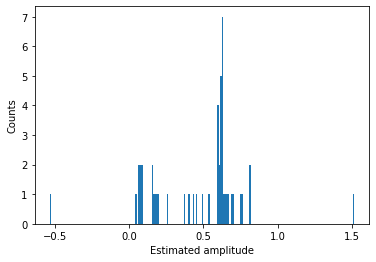

In [11]:
hist = plt.hist(estimates, bins=200)
plt.xlabel("Estimated amplitude")
plt.ylabel("Counts")
print("majoritary bin: {} - {}".format(hist[1][np.argmax(hist[0]) - 1], hist[1][np.argmax(hist[0]) + 1]))

In [12]:
hist

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 2.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 4., 2., 5., 7., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-5.32420088e-01, -5.22191390e-01, -5.11962691e-01, -5.01733992e-01,
        -4.91505293e-01, -